In [13]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Read the data
data = pd.read_csv('data/all-deals.csv')

data.head()

,Record ID,Project Plan,# of Agents Contracted,# of Agents Total,% Auto Renewal Increase,24/7 Support?,Abandoned cart URL,Amount,Amount in company currency,Annual contract value,Annual recurring revenue,BANT,BANT DEAL. PAIN ID'ED,Billing Contact,Billing Contact Email,Billing Contact Telephone,BPO,BPO Program,BPO Program Tier,Campaign of last booking in meetings tool,CCaaS,Close Date,Closed Lost Date,Closed Lost Reason,Closed Lost Status,CLOSED TRIAL,CLOSED WON,Closed won count,Closed Won Reason,Comments,Competitive Trial?,Confidence %,Contract End Date,CONTRACT SENT,Contract Start Date,Contract Term (Months),Country Located In,Create Date,Created by user ID,CSAT Follow Up,CSM Owner,"Cumulative time in ""BANT Deal. Pain ID'ed (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Closed Lost (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Closed Trial (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Closed Won (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Contract Sent (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Deep Dive. PSP Drafted (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""In Trial - Trial in Progress (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Negotiation (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Opportunity (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Partner Referrals (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Renewals (Sales Pipeline)"" (HH:mm:ss)",Current licenses Active,Customer Status-Deal,"Date entered ""BANT Deal. Pain ID'ed (Sales Pipeline)""","Date entered ""Closed Lost (Sales Pipeline)""","Date entered ""Closed Trial (Sales Pipeline)""","Date entered ""Closed Won (Sales Pipeline)""","Date entered ""Contract Sent (Sales Pipeline)""","Date entered ""Deep Dive. PSP Drafted (Sales Pipeline)""","Date entered ""In Trial - Trial in Progress (Sales Pipeline)""","Date entered ""Negotiation (Sales Pipeline)""","Date entered ""Opportunity (Sales Pipeline)""","Date entered ""Partner Referrals (Sales Pipeline)""","Date entered ""Renewals (Sales Pipeline)""","Date exited ""BANT Deal. Pain ID'ed (Sales Pipeline)""","Date exited ""Closed Lost (Sales Pipeline)""","Date exited ""Closed Trial (Sales Pipeline)""","Date exited ""Closed Won (Sales Pipeline)""","Date exited ""Contract Sent (Sales Pipeline)""","Date exited ""Deep Dive. PSP Drafted (Sales Pipeline)""","Date exited ""In Trial - Trial in Progress (Sales Pipeline)""","Date exited ""Negotiation (Sales Pipeline)""","Date exited ""Opportunity (Sales Pipeline)""","Date exited ""Partner Referrals (Sales Pipeline)""","Date exited ""Renewals (Sales Pipeline)""",Date of last meeting booked in meetings tool,Date Partner Registered,Days to close,Deal Collaborator,Deal Description,Deal Lead Source,Deal Name,Deal owner,Deal probability,Deal Score,Deal source attribution 1,Deal source attribution 2,Deal source attribution 3,Deal Stage,Deal Tags,Deal Type,DEEP DIVE. PSP DRAFTED,Discount savings,Discovery Completed,Ecommerce deal,Ecosystem,Exchange rate,Expected growth revenue,Expected licenses,Follow up - Contract End Date,Forecast amount,Forecast category,Forecast probability,Free Trial Form Submission,Growth,Has Auto Renewal,HRMS / HRIS,HubSpot Team,Implementation Manager,Include SSO,Invoice Frequency,Is Closed (numeric),Is closed lost,Is Closed Won,Is Deal Closed?,Is Open (numeric),Last Activity Date,Last Contacted,Last Modified Date,Latest Approval Status,"Latest time in ""BANT Deal. Pain ID'ed (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""Closed Lost (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""Closed Trial (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""Closed Won (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""Contract Sent (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""Deep Dive. PSP Drafted (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""In Trial - Trial in Progress (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""Negotiation (Sales Pipeline)"" (HH:mm:ss)","Latest time in ""Opportunity (Sales Pip

In [14]:
import pandas as pd
import numpy as np
import hashlib
import re
from typing import Dict, List, Tuple, Set, Optional
import json


class HubspotDataAnonymizer:
    """
    A class to anonymize Hubspot deals data by removing or masking
    personally identifiable information (PII) and other sensitive data.
    """
    
    def __init__(self, input_file: str):
        """
        Initialize the anonymizer with the path to the input file.
        
        Args:
            input_file (str): Path to the Hubspot deals CSV file
        """
        self.input_file = input_file
        self.data = None
        self.mapping_tables = {}
    
    def load_data(self) -> pd.DataFrame:
        """
        Load the CSV data into a pandas DataFrame.
        
        Returns:
            pd.DataFrame: The loaded data
        """
        print(f"Loading data from {self.input_file}...")
        self.data = pd.read_csv(self.input_file, low_memory=False)
        print(f"Loaded {len(self.data)} rows and {len(self.data.columns)} columns")
        return self.data
    
    def get_columns_to_remove(self) -> List[str]:
        """
        Returns a list of columns to completely remove from the dataset.
        
        Returns:
            List[str]: Columns to remove
        """
        # Personal identifiers
        personal_identifiers = [
            "Billing Contact", "Created by user ID", "Updated by user ID", 
            "CSM Owner", "Referral Agent", "Master Agent", "Implementation Manager",
            "Coach-", "User-", "Associated Contact"
        ]
        
        # Contact information
        contact_info = [
            "Billing Contact Email", "Billing Contact Telephone",
            "Associated Email", "Associated Meeting"
        ]
        
        # Detailed notes and comments
        notes_comments = [
            "Comments", "Associated Note", "Next step", 
            "Associated Task", "Associated Call"
        ]
        
        # External IDs and references
        external_ids = [
            "Salesforce Opportunity ID", "Associated Contact IDs", 
            "Associated Meeting IDs", "Associated Email IDs", 
            "Associated Task IDs", "Associated Note IDs", 
            "Associated Call IDs", "Merged Deal IDs"
        ]
        
        # URLs and links
        urls = [
            "Abandoned cart URL", "Links to Sales Task that is based on the Deal (hidden)",
            "Associated Payment Link", "Associated Payment Link IDs"
        ]
        
        # All columns ending with "IDs" are likely to contain identifiers
        id_columns = [col for col in self.data.columns if col.endswith(" IDs") or col.endswith("IDs")]
        
        # Combine all columns to remove
        columns_to_remove = list(set(
            personal_identifiers + 
            contact_info + 
            notes_comments + 
            external_ids + 
            urls + 
            id_columns
        ))
        
        # Verify these columns exist in the data
        existing_columns = [col for col in columns_to_remove if col in self.data.columns]
        
        return existing_columns
    
    def get_columns_to_anonymize(self) -> Dict[str, str]:
        """
        Returns a dictionary of columns to anonymize and their anonymization method.
        
        Returns:
            Dict[str, str]: Mapping of column name to anonymization method
        """
        return {
            "Deal owner": "hash",
            "Deal Name": "hash",
            "Associated Company (Primary)": "hash",
            "Associated Company": "hash",
            "Deal Description": "truncate"
        }
    
    def get_columns_to_keep(self) -> List[str]:
        """
        Returns the list of columns to keep for analysis.
        
        Returns:
            List[str]: Columns to keep
        """
        essential_columns = [
            # Primary identifier
            "Record ID",
            
            # Deal information
            "Amount", "Amount in company currency", "Close Date", "Create Date",
            "Days to close", "Deal Stage", "Deal Type", "Deal Score", "Deal probability",
            "Pipeline", "Forecast amount", "Forecast category", "Forecast probability",
            
            # Status flags
            "Is Closed (numeric)", "Is closed lost", "Is Closed Won", "Is Deal Closed?",
            "Is Open (numeric)",
            
            # Time metrics
            "Cumulative time in \"BANT Deal. Pain ID'ed (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Closed Lost (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Closed Trial (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Closed Won (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Contract Sent (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Deep Dive. PSP Drafted (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"In Trial - Trial in Progress (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Negotiation (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Opportunity (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Partner Referrals  (Sales Pipeline)\" (HH:mm:ss)",
            "Cumulative time in \"Renewals  (Sales Pipeline)\" (HH:mm:ss)",
            
            # Deal source information
            "Deal source attribution 2",
            "Original Traffic Source",
            
            # Financial metrics
            "Annual contract value", 
            "Annual recurring revenue",
            "Monthly recurring revenue",
            "Total contract value",
            "Weighted amount",
            "Weighted amount in company currency",
            
            # Deal metadata
            "Contract Term (Months)",
            "Contract End Date",
            "Contract Start Date",
            "Last Activity Date",
            "Last Modified Date",
            "Trial End Date",
            "Trial Start date"
        ]
        
        # Check which columns actually exist in the data
        available_columns = [col for col in essential_columns if col in self.data.columns]
        
        # Add the columns we need to anonymize (they'll be kept in the dataset but transformed)
        to_anonymize = list(self.get_columns_to_anonymize().keys())
        available_to_anonymize = [col for col in to_anonymize if col in self.data.columns]
        
        return list(set(available_columns + available_to_anonymize))
    
    def anonymize_column(self, column_name: str, method: str) -> Tuple[pd.Series, Dict]:
        """
        Anonymize a column using the specified method.
        
        Args:
            column_name (str): Name of the column to anonymize
            method (str): Anonymization method ('hash', 'truncate', etc.)
            
        Returns:
            Tuple[pd.Series, Dict]: Anonymized column and mapping dictionary
        """
        column = self.data[column_name]
        mapping = {}
        
        if method == "hash":
            # Replace each unique value with a hashed identifier
            unique_values = column.dropna().unique()
            
            for value in unique_values:
                if pd.notna(value) and value != "":
                    # Create a hash based on the category and value
                    prefix = column_name.split()[0]  # Use first word of column name as prefix
                    hash_obj = hashlib.md5(str(value).encode())
                    hash_hex = hash_obj.hexdigest()[:8]  # Take first 8 chars of hash
                    mapping[value] = f"{prefix}_{hash_hex}"
            
            # Apply the mapping to the column
            anonymized = column.map(lambda x: mapping.get(x, x) if pd.notna(x) else x)
            
        elif method == "truncate":
            # Truncate and remove specific details
            anonymized = column.apply(
                lambda x: self._truncate_text(x) if isinstance(x, str) else x
            )
            mapping = None  # No mapping needed for truncation
            
        else:
            raise ValueError(f"Unknown anonymization method: {method}")
        
        return anonymized, mapping
    
    def _truncate_text(self, text: str, max_length: int = 50) -> str:
        """
        Truncate text and remove potential identifying information.
        
        Args:
            text (str): Text to truncate
            max_length (int): Maximum length to keep
            
        Returns:
            str: Truncated, cleaned text
        """
        if not isinstance(text, str):
            return text
            
        # Remove email addresses
        text = re.sub(r'\S+@\S+\.\S+', '[EMAIL]', text)
        
        # Remove phone numbers
        text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '[PHONE]', text)
        
        # Remove URLs
        text = re.sub(r'https?://\S+', '[URL]', text)
        
        # Truncate if longer than max_length
        if len(text) > max_length:
            text = text[:max_length] + "..."
            
        return text
    
    def first_pass_anonymization(self) -> Tuple[pd.DataFrame, Dict]:
        """
        Perform the first pass of data anonymization:
        1. Remove unnecessary columns
        2. Anonymize sensitive columns
        
        Returns:
            Tuple[pd.DataFrame, Dict]: Anonymized DataFrame and mapping dictionaries
        """
        if self.data is None:
            self.load_data()
        
        # Get lists of columns to process
        columns_to_remove = self.get_columns_to_remove()
        columns_to_anonymize = self.get_columns_to_anonymize()
        columns_to_keep = self.get_columns_to_keep()
        
        # Start with only the columns we want to keep
        print(f"Keeping {len(columns_to_keep)} columns out of {len(self.data.columns)}")
        reduced_df = self.data[columns_to_keep].copy()
        
        # Anonymize columns
        for column, method in columns_to_anonymize.items():
            if column in reduced_df.columns:
                print(f"Anonymizing column: {column} using method: {method}")
                reduced_df[column], mapping = self.anonymize_column(column, method)
                if mapping:
                    self.mapping_tables[column] = mapping
        
        # Remove any columns that should be removed but might still be in our dataset
        columns_to_drop = [col for col in reduced_df.columns if col in columns_to_remove]
        if columns_to_drop:
            print(f"Dropping {len(columns_to_drop)} additional columns")
            reduced_df = reduced_df.drop(columns=columns_to_drop)
        
        return reduced_df, self.mapping_tables
    

In [15]:
anonymizer = HubspotDataAnonymizer("data/all-deals.csv")

# Load and anonymize the data
anonymized_data, mappings = anonymizer.first_pass_anonymization()

# Assuming anonymized_data is your DataFrame
anonymized_data.to_csv('data/anonymized_data.csv', index=False)
print("Anonymized data saved to anonymized_data.csv")

# Assuming mapping_tables is your dictionary of mappings
with open('data/mapping_tables.json', 'w') as f:
    json.dump(mappings, f, indent=2)
print("Mapping tables saved to mapping_tables.json")


Loading data from data/all-deals.csv...
Loaded 593 rows and 305 columns
Keeping 50 columns out of 305
Anonymizing column: Deal owner using method: hash
Anonymizing column: Deal Name using method: hash
Anonymizing column: Associated Company (Primary) using method: hash
Anonymizing column: Associated Company using method: hash
Anonymizing column: Deal Description using method: truncate
Anonymized data saved to anonymized_data.csv
Mapping tables saved to mapping_tables.json


In [16]:

# Display information about the anonymized dataset
print(f"\nAnonymized dataset shape: {anonymized_data.shape}")
print("\nSample of anonymized data:")
print(anonymized_data.head())

# Display some stats about the data
print("\nKey statistics:")
print(f"Total deals: {len(anonymized_data)}")
print(f"Closed won deals: {anonymized_data['Is Closed Won'].sum()}")
print(f"Closed lost deals: {anonymized_data['Is closed lost'].sum()}")
print(f"Open deals: {anonymized_data['Is Open (numeric)'].sum()}")


Anonymized dataset shape: (593, 50)

Sample of anonymized data:
   Weighted amount                       Deal Description Cumulative time in "BANT Deal. Pain ID'ed (Sales Pipeline)" (HH:mm:ss) Cumulative time in "Opportunity (Sales Pipeline)" (HH:mm:ss)  Days to close  Deal Score        Close Date Deal source attribution 2 Cumulative time in "In Trial - Trial in Progress (Sales Pipeline)" (HH:mm:ss) Contract Start Date Cumulative time in "Partner Referrals  (Sales Pipeline)" (HH:mm:ss) Cumulative time in "Closed Lost (Sales Pipeline)" (HH:mm:ss) Cumulative time in "Deep Dive. PSP Drafted (Sales Pipeline)" (HH:mm:ss)        Pipeline    Record ID Forecast category Original Traffic Source   Associated Company     Deal owner  Annual contract value  Is Closed (numeric)  Amount in company currency  Annual recurring revenue  Monthly recurring revenue  Deal probability Associated Company (Primary)  Is Closed Won  Forecast probability Contract End Date Last Activity Date  Contract Term (Months

In [17]:
anonymized_data.head()

,Weighted amount,Deal Description,"Cumulative time in ""BANT Deal. Pain ID'ed (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Opportunity (Sales Pipeline)"" (HH:mm:ss)",Days to close,Deal Score,Close Date,Deal source attribution 2,"Cumulative time in ""In Trial - Trial in Progress (Sales Pipeline)"" (HH:mm:ss)",Contract Start Date,"Cumulative time in ""Partner Referrals (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Closed Lost (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Deep Dive. PSP Drafted (Sales Pipeline)"" (HH:mm:ss)",Pipeline,Record ID,Forecast category,Original Traffic Source,Associated Company,Deal owner,Annual contract value,Is Closed (numeric),Amount in company currency,Annual recurring revenue,Monthly recurring revenue,Deal probability,Associated Company (Primary),Is Closed Won,Forecast probability,Contract End Date,Last Activity Date,Contract Term (Months),Trial Start date,Is closed lost,Weighted amount in company currency,Is Deal Closed?,Trial End Date,Deal Name,Amount,"Cumulative time in ""Closed Trial (Sales Pipeline)"" (HH:mm:ss)",Forecast amount,"Cumulative time in ""Negotiation (Sales Pipeline)"" (HH:mm:ss)",Is Open (numeric),"Cumulative time in ""Renewals (Sales Pipeline)"" (HH:mm:ss)",Create Date,"Cumulative time in ""Contract Sent (Sales Pipeline)"" (HH:mm:ss)",Total contract value,Last Modified Date,"Cumulative time in ""Closed Won (Sales Pipeline)"" (HH:mm:ss)",Deal Stage,Deal Type
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26,Event,NaN,NaN,NaN,NaN,NaN,Sales Pipeline,33774471298,Pipeline,Offline Sources,Associated_9ea45ab3,Deal_17defa5f,NaN,0.0,1250.0,NaN,NaN,0.20,Associated_9ea45ab3,False,NaN,NaN,2025-02-20 14:06,NaN,NaN,False,250.0,False,NaN,Deal_a52f6464,1250.0,NaN,1250.0,NaN,1.0,NaN,2025-02-20 15:27,NaN,NaN,2025-02-20 16:28,NaN,Opportunity,New
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06,Referral Partner,NaN,NaN,NaN,NaN,NaN,Sales Pipeline,33735737768,Not forecasted,Offline Sources,Associated_77e18366,Deal_3d3dc242,NaN,0.0,0.0,NaN,NaN,0.05,Associated_77e18366,False,NaN,NaN,NaN,NaN,NaN,False,0.0,False,NaN,Deal_b152b9c3,0.0,NaN,0.0,NaN,1.0,NaN,2025-02-20 08:07,NaN,NaN,2025-02-20 09:08,NaN,Partner Referrals,New
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03,Referral Partner,NaN,NaN,NaN,NaN,NaN,Sales Pipeline,33758455618,Not forecasted,Offline Sources,Associated_77e18366,Deal_3d3dc242,NaN,0.0,0.0,NaN,NaN,0.05,Associated_77e18366,False,NaN,NaN,NaN,NaN,NaN,False,0.0,False,NaN,Deal_edbdb698,0.0,NaN,0.0,NaN,1.0,NaN,2025-02-20 08:04,NaN,NaN,2025-02-20 09:05,NaN,Partner Referrals,New
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55,Referral Partner,NaN,NaN,NaN,NaN,NaN,Sales Pipeline,33741931267,Not forecasted,Offline Sources,Associated_77e18366,Deal_3d3dc242,NaN,0.0,0.0,NaN,NaN,0.05,Associated_77e18366,False,NaN,NaN,NaN,NaN,NaN,False,0.0,False,NaN,Deal_e5cfc33e,0.0,NaN,0.0,NaN,1.0,NaN,2025-02-20 07:58,NaN,NaN,2025-02-20 08:59,NaN,Partner Referrals,New
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01,Master Agent,NaN,NaN,NaN,NaN,NaN,Sales Pipeline,33724679941,Best case,Offline Sources,Associated_edbdb698,Deal_3d3dc242,NaN,0.0,50000.0,NaN,NaN,0.20,Associated_edbdb698,False,NaN,NaN,2025-02-14 15:30,NaN,NaN,False,10000.0,False,NaN,Deal_edbdb698,50000.0,NaN,50000.0,NaN,1.0,NaN,2025-02-19 14:02,NaN,NaN,2025-02-19 15:03,NaN,Deep Dive. PSP Drafted,New


In [18]:
class HubspotDealsAnalyzer:
    def __init__(self, data):
        self.data = data
        self.processed_data = None
    
    def preprocess_data(self):
        """Perform initial preprocessing on the anonymized data"""
        df = self.data.copy()
        
        # Convert date strings to datetime objects
        date_columns = ['Close Date', 'Create Date', 'Contract Start Date', 'Contract End Date', 
                         'Last Activity Date', 'Last Modified Date', 'Trial Start date', 'Trial End Date']
        
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Create additional date-based features
        if 'Create Date' in df.columns:
            df['Create Year'] = df['Create Date'].dt.year
            df['Create Month'] = df['Create Date'].dt.month
            df['Create Quarter'] = df['Create Date'].dt.quarter
        
        if 'Close Date' in df.columns:
            df['Close Year'] = df['Close Date'].dt.year
            df['Close Month'] = df['Close Date'].dt.month
            df['Close Quarter'] = df['Close Date'].dt.quarter
            
        # Calculate time in pipeline features
        if 'Create Date' in df.columns and 'Close Date' in df.columns:
            # Time from creation to close (for closed deals)
            mask = ~df['Close Date'].isna()
            df.loc[mask, 'Days_in_Pipeline'] = (df.loc[mask, 'Close Date'] - 
                                               df.loc[mask, 'Create Date']).dt.days
        
        # Deal size categorization
        if 'Amount' in df.columns:
            df['Deal_Size_Category'] = pd.cut(
                df['Amount'], 
                bins=[0, 10000, 50000, 100000, float('inf')],
                labels=['Small', 'Medium', 'Large', 'Enterprise']
            )
        
        self.processed_data = df
        return df
    
    def extract_pipeline_metrics(self):
        """Extract key metrics about the sales pipeline"""
        if self.processed_data is None:
            self.preprocess_data()
            
        df = self.processed_data
        
        # Calculate win rates by various dimensions
        metrics = {}
        
        # Overall win rate
        total_closed = df['Is Closed Won'].sum() + df['Is closed lost'].sum()
        if total_closed > 0:
            metrics['overall_win_rate'] = df['Is Closed Won'].sum() / total_closed * 100
        
        # Win rate by source
        if 'Deal source attribution 2' in df.columns:
            win_rate_by_source = df.groupby('Deal source attribution 2').apply(
                lambda x: x['Is Closed Won'].sum() / (x['Is Closed Won'].sum() + x['Is closed lost'].sum()) * 100 
                if (x['Is Closed Won'].sum() + x['Is closed lost'].sum()) > 0 else 0
            ).sort_values(ascending=False)
            
            metrics['win_rate_by_source'] = win_rate_by_source.to_dict()
        
        # Average deal size
        if 'Amount' in df.columns:
            metrics['avg_deal_size'] = df['Amount'].mean()
            metrics['median_deal_size'] = df['Amount'].median()
            
            # Average deal size by stage
            if 'Deal Stage' in df.columns:
                avg_by_stage = df.groupby('Deal Stage')['Amount'].mean().to_dict()
                metrics['avg_deal_size_by_stage'] = avg_by_stage
        
        # Time metrics
        if 'Days_in_Pipeline' in df.columns:
            metrics['avg_days_to_close_won'] = df[df['Is Closed Won'] == True]['Days_in_Pipeline'].mean()
            metrics['avg_days_to_close_lost'] = df[df['Is closed lost'] == True]['Days_in_Pipeline'].mean()
        
        return metrics
    
    def analyze_pipeline_stages(self):
        """Analyze deal flow through pipeline stages"""
        if self.processed_data is None:
            self.preprocess_data()
            
        df = self.processed_data
        
        if 'Deal Stage' not in df.columns:
            return None
            
        # Count deals by stage
        stage_counts = df['Deal Stage'].value_counts().to_dict()
        
        # Calculate conversion rates between stages
        stage_conversion = {}
        stages = ['Opportunity', 'BANT Deal. Pain ID\'ed', 'Deep Dive. PSP Drafted', 
                 'In Trial - Trial in Progress', 'Negotiation', 'Contract Sent', 'Closed Won']
        
        # For each consecutive pair of stages
        for i in range(len(stages)-1):
            current = stages[i]
            next_stage = stages[i+1]
            
            current_count = len(df[df['Deal Stage'] == current])
            next_count = len(df[df['Deal Stage'] == next_stage])
            
            if current_count > 0:
                stage_conversion[f"{current} → {next_stage}"] = next_count / current_count * 100
        
        return {
            'stage_counts': stage_counts,
            'stage_conversion': stage_conversion
        }
    
    def analyze_temporal_trends(self):
        """Analyze trends over time"""
        if self.processed_data is None:
            self.preprocess_data()
            
        df = self.processed_data
        
        # Group data by month
        if 'Create Year' in df.columns and 'Create Month' in df.columns:
            df['YearMonth'] = df['Create Year'].astype(str) + '-' + df['Create Month'].astype(str).str.zfill(2)
            
            monthly_data = df.groupby('YearMonth').agg({
                'Record ID': 'count',
                'Amount': ['sum', 'mean'],
                'Is Closed Won': 'sum',
                'Is closed lost': 'sum'
            })
            
            # Calculate win rate by month
            monthly_data['win_rate'] = monthly_data[('Is Closed Won', 'sum')] / (
                monthly_data[('Is Closed Won', 'sum')] + monthly_data[('Is closed lost', 'sum')]
            ) * 100
            
            return monthly_data.sort_index()
        
        return None

Processed data shape: (593, 58)

Key Pipeline Metrics:
Overall Win Rate: 37.26%
Average Deal Size: $40,013.28
Median Deal Size: $24,000.00
Avg Days to Close (Won): 142.7
Avg Days to Close (Lost): 160.8

Deal Counts by Stage:
Closed Lost: 266
Closed Won: 158
Partner Referrals : 67
Opportunity: 32
Renewals : 15
Negotiation: 15
Deep Dive. PSP Drafted: 13
Contract Sent: 10
BANT Deal. Pain ID'ed: 10
In Trial - Trial in Progress: 5
Closed Trial: 2

Monthly Trends Summary (last 12 months):
          Record ID     Amount                Is Closed Won Is closed lost    win_rate
              count        sum           mean           sum            sum            
YearMonth                                                                             
2024-03          40   760200.0   19005.000000             5             10   33.333333
2024-04          31   561000.0   18096.774194             3              6   33.333333
2024-05          20   130000.0    6500.000000             2              3   

/var/folders/mp/prth0l3j2s12n12hngf32kmw0000gp/T/ipykernel_37114/1951634664.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  win_rate_by_source = df.groupby('Deal source attribution 2').apply(


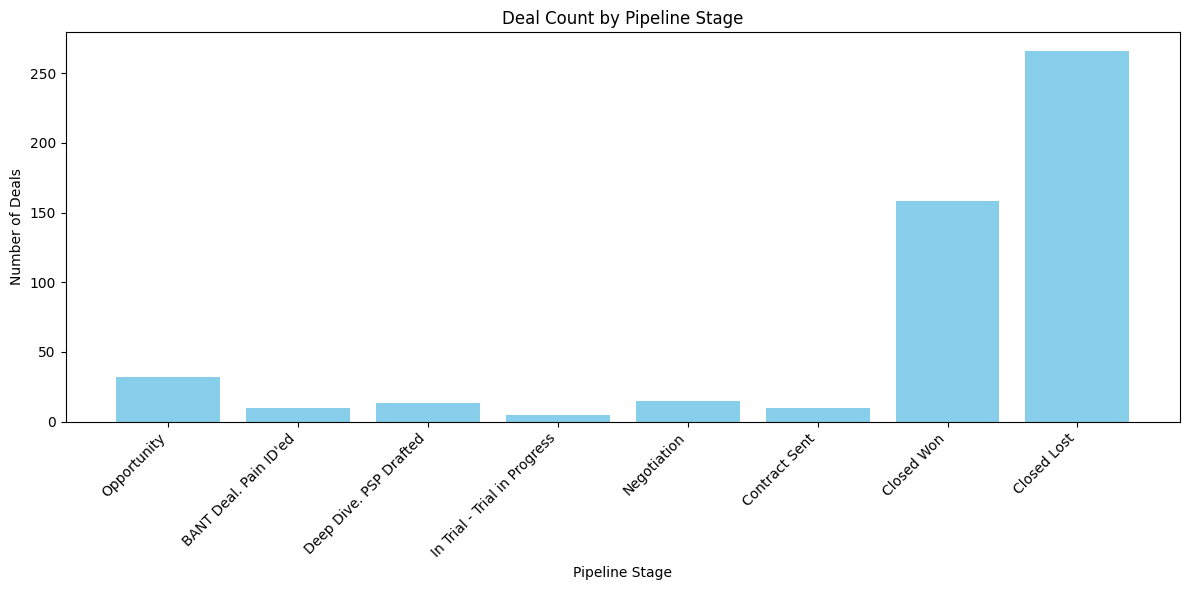

In [ ]:
# Step 1: Import your analyzer class
# (This assumes your anonymized DataFrame is already created and named 'anonymized_data')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Initialize the analyzer with your anonymized DataFrame
analyzer = HubspotDealsAnalyzer(anonymized_data)

# Step 3: Preprocess the data
processed_data = analyzer.preprocess_data()
print(f"Processed data shape: {processed_data.shape}")

# Step 4: Extract pipeline metrics
pipeline_metrics = analyzer.extract_pipeline_metrics()
print("\nKey Pipeline Metrics:")
print(f"Overall Win Rate: {pipeline_metrics.get('overall_win_rate', 'N/A'):.2f}%")
print(f"Average Deal Size: ${pipeline_metrics.get('avg_deal_size', 'N/A'):,.2f}")
print(f"Median Deal Size: ${pipeline_metrics.get('median_deal_size', 'N/A'):,.2f}")
print(f"Avg Days to Close (Won): {pipeline_metrics.get('avg_days_to_close_won', 'N/A'):.1f}")
print(f"Avg Days to Close (Lost): {pipeline_metrics.get('avg_days_to_close_lost', 'N/A'):.1f}")

# Step 5: Analyze pipeline stages
stage_analysis = analyzer.analyze_pipeline_stages()
if stage_analysis:
    print("\nDeal Counts by Stage:")
    for stage, count in stage_analysis['stage_counts'].items():
        print(f"{stage}: {count}")

# Step 6: Analyze temporal trends
temporal_trends = analyzer.analyze_temporal_trends()
if temporal_trends is not None:
    print("\nMonthly Trends Summary (last 12 months):")
    print(temporal_trends.tail(12))

# Step 7: Visualize key insights (optional)
# Example: Plot the deal stage distribution
plt.figure(figsize=(12, 6))
if stage_analysis:
    stages = list(stage_analysis['stage_counts'].keys())
    counts = list(stage_analysis['stage_counts'].values())
    
    # Sort by ideal pipeline order if possible
    ideal_order = ['Opportunity', 'BANT Deal. Pain ID\'ed', 'Deep Dive. PSP Drafted', 
                  'In Trial - Trial in Progress', 'Negotiation', 'Contract Sent', 
                  'Closed Won', 'Closed Lost']
    
    ordered_data = []
    for stage in ideal_order:
        if stage in stage_analysis['stage_counts']:
            ordered_data.append((stage, stage_analysis['stage_counts'][stage]))
        
    
    if ordered_data:
        stages, counts = zip(*ordered_data)
    
    plt.bar(stages, counts, color='skyblue')
    plt.title('Deal Count by Pipeline Stage')
    plt.xlabel('Pipeline Stage')
    plt.ylabel('Number of Deals')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [20]:
import pandas as pd
import numpy as np
import hashlib
import re
import json
from typing import Dict, List, Tuple, Optional

class TicketDataAnonymizer:
    """
    A class to anonymize Hubspot ticket data while maintaining consistent
    anonymization with previously anonymized deal data.
    """
    
    def __init__(self, 
                 ticket_file: str, 
                 existing_mappings_file: Optional[str] = None):
        """
        Initialize the anonymizer with the path to the ticket data file
        and optionally a file containing existing anonymization mappings.
        
        Args:
            ticket_file (str): Path to the Hubspot tickets CSV file
            existing_mappings_file (str, optional): Path to JSON file with existing mappings
        """
        self.ticket_file = ticket_file
        self.data = None
        self.mapping_tables = {}
        self.existing_mappings = {}
        
        # Load existing mappings if provided
        if existing_mappings_file:
            try:
                with open(existing_mappings_file, 'r') as f:
                    self.existing_mappings = json.load(f)
                print(f"Loaded existing mappings from {existing_mappings_file}")
            except Exception as e:
                print(f"Warning: Could not load existing mappings: {e}")
    
    def load_data(self) -> pd.DataFrame:
        """
        Load the CSV data into a pandas DataFrame.
        
        Returns:
            pd.DataFrame: The loaded data
        """
        print(f"Loading ticket data from {self.ticket_file}...")
        self.data = pd.read_csv(self.ticket_file, low_memory=False)
        print(f"Loaded {len(self.data)} rows and {len(self.data.columns)} columns")
        return self.data
    
    def get_columns_to_remove(self) -> List[str]:
        """
        Returns a list of columns to completely remove from the dataset.
        
        Returns:
            List[str]: Columns to remove
        """
        # Personal identifiers
        personal_identifiers = [
            "Created by user ID", "Updated by user ID", "CSM", 
            "Implementation Manager", "Sym Creator", "Ticket owner",
            "Relationship Owner", "Jira issue assignee", "Jira issue reporter"
        ]
        
        # Detailed notes and free text that might contain PII
        notes_comments = [
            "Ticket description", "Last CES survey comment", 
            "Provide an explanation for the extended duration", 
            "Reason for Edits - Product Constraints - Explanation"
        ]
        
        # External IDs and references
        external_ids = [
            "Merged Ticket IDs", "Jira issue ID", "Jira issue identifier",
            "Associated Email IDs", "Associated Contact IDs", "Associated Company IDs",
            "Associated Deal IDs", "Associated Note IDs", "Associated Task IDs",
            "Associated Conversation IDs", "Associated Meeting IDs", "Associated Call IDs"
        ]
        
        # URLs and links
        urls = [
            "Jira issue link", "Attachment", "File upload"
        ]
        
        # All columns ending with "IDs" are likely to contain identifiers
        id_columns = [col for col in self.data.columns if col.endswith(" IDs")]
        
        # Combine all columns to remove
        columns_to_remove = list(set(
            personal_identifiers + 
            notes_comments + 
            external_ids + 
            urls + 
            id_columns
        ))
        
        # Verify these columns exist in the data
        existing_columns = [col for col in columns_to_remove if col in self.data.columns]
        
        return existing_columns
    
    def get_columns_to_anonymize(self) -> Dict[str, str]:
        """
        Returns a dictionary of columns to anonymize and their anonymization method.
        
        Returns:
            Dict[str, str]: Mapping of column name to anonymization method
        """
        return {
            "Ticket name": "hash",
            "Associated Company": "hash",
            "Associated Company (Primary)": "hash",
            "Associated Deal": "hash",
            "Associated Contact": "hash",
            "Who will be creating the Syms?": "hash"
        }
    
    def get_columns_to_keep(self) -> List[str]:
        """
        Returns the list of columns to keep for analysis.
        
        Returns:
            List[str]: Columns to keep
        """
        essential_columns = [
            # Primary identifier
            "Ticket ID",
            
            # Ticket information
            "Create date", "Close date", "Last modified date", "Ticket status",
            "Priority", "Type", "Category", "Pipeline", "Ticket Tags",
            
            # Project phases and dates
            "Latest Milestone", "Latest Milestone Update Date",
            "Stage Date - Project Initiation", "Stage Date - Project Launch", 
            "Stage Date - Execution", "Stage Date - Closure Phase",
            "Stage Date - Converted Won", "Stage Date - Monitoring and Control Phase",
            "Stage Date - Planning Phase", "Target Launch Date",
            
            # Implementation details
            "1st Syms presented for review", "1st Syms approved for production",
            "1st syms run in production", "Construction of 1st Sym begun",
            "Deployment plan approved", "Library index approved",
            "Kickoff Call", "GNG Call", "Project Launch Day",
            
            # Training information
            "Training: Sym Building 101", "Training: Sym Building 201",
            "Training: General Overview", "Training: Reporting",
            "Training: Deployment/User Management Training",
            
            # Metrics and performance
            "Time to close (HH:mm:ss)", "Response time (HH:mm:ss)",
            "Time to first agent email reply (HH:mm:ss)",
            "Was the sym QAed?", "Last CES survey rating",
            
            # Trial information
            "Trial Required", "Trial Start Date", "Trial End Date",
            "Requirements for the Trial", "Trial Overview",
            
            # Relationships (to be anonymized)
            "Associated Deal", "Associated Company", "Associated Company (Primary)"
        ]
        
        # Check which columns actually exist in the data
        available_columns = [col for col in essential_columns if col in self.data.columns]
        
        # Add the columns we need to anonymize (they'll be kept but transformed)
        to_anonymize = list(self.get_columns_to_anonymize().keys())
        available_to_anonymize = [col for col in to_anonymize if col in self.data.columns]
        
        return list(set(available_columns + available_to_anonymize))
    
    def anonymize_column(self, column_name: str, method: str) -> Tuple[pd.Series, Dict]:
        """
        Anonymize a column using the specified method, maintaining consistency
        with existing anonymized values.
        
        Args:
            column_name (str): Name of the column to anonymize
            method (str): Anonymization method ('hash', 'truncate', etc.)
            
        Returns:
            Tuple[pd.Series, Dict]: Anonymized column and mapping dictionary
        """
        column = self.data[column_name]
        
        # Start with any existing mappings if available
        mapping = {}
        existing_column_mappings = self.existing_mappings.get(column_name, {})
        if existing_column_mappings:
            # Convert keys back to original type if needed
            mapping = {k: v for k, v in existing_column_mappings.items()}
        
        if method == "hash":
            # Replace each unique value with a hashed identifier
            unique_values = column.dropna().unique()
            
            # Determine prefix based on column
            if 'Company' in column_name:
                prefix = 'Company'
            elif 'Deal' in column_name:
                prefix = 'Deal'
            elif 'Contact' in column_name:
                prefix = 'Contact'
            else:
                prefix = column_name.split()[0]  # Use first word of column name
            
            for value in unique_values:
                # Skip empty values
                if pd.isna(value) or value == "":
                    continue
                    
                # If value already has a mapping, use it
                if str(value) in mapping:
                    continue
                    
                # Otherwise create new mapping
                hash_obj = hashlib.md5(str(value).encode())
                hash_hex = hash_obj.hexdigest()[:8]
                mapping[str(value)] = f"{prefix}_{hash_hex}"
            
            # Apply the mapping to the column
            anonymized = column.map(lambda x: mapping.get(str(x), x) if pd.notna(x) else x)
            
        elif method == "truncate":
            # Truncate and remove specific details
            anonymized = column.apply(
                lambda x: self._truncate_text(x) if isinstance(x, str) else x
            )
            mapping = None  # No mapping needed for truncation
            
        else:
            raise ValueError(f"Unknown anonymization method: {method}")
        
        return anonymized, mapping
    
    def _truncate_text(self, text: str, max_length: int = 50) -> str:
        """
        Truncate text and remove potential identifying information.
        
        Args:
            text (str): Text to truncate
            max_length (int): Maximum length to keep
            
        Returns:
            str: Truncated, cleaned text
        """
        if not isinstance(text, str):
            return text
            
        # Remove email addresses
        text = re.sub(r'\S+@\S+\.\S+', '[EMAIL]', text)
        
        # Remove phone numbers
        text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '[PHONE]', text)
        
        # Remove URLs
        text = re.sub(r'https?://\S+', '[URL]', text)
        
        # Truncate if longer than max_length
        if len(text) > max_length:
            text = text[:max_length] + "..."
            
        return text

    def create_deal_relationship_mapping(self) -> Dict:
        """
        Creates a mapping between ticket IDs and their associated anonymous deal IDs.
        
        Returns:
            Dict: Mapping of ticket IDs to anonymized deal IDs
        """
        if 'Associated Deal' not in self.data.columns:
            return {}
            
        # Get the mapping for Associated Deal
        associated_deal_mapping = self.mapping_tables.get('Associated Deal', {})
        
        # Create mapping from ticket ID to anonymized deal ID
        ticket_to_deal = {}
        for _, row in self.data.iterrows():
            ticket_id = row['Ticket ID']
            deal = row.get('Associated Deal')
            
            if pd.notna(deal) and str(deal) in associated_deal_mapping:
                ticket_to_deal[ticket_id] = associated_deal_mapping[str(deal)]
                
        return ticket_to_deal
    
    def anonymize_data(self) -> Tuple[pd.DataFrame, Dict]:
        """
        Perform data anonymization:
        1. Remove unnecessary columns
        2. Anonymize sensitive columns
        3. Create relationship mappings
        
        Returns:
            Tuple[pd.DataFrame, Dict]: Anonymized DataFrame and mapping dictionaries
        """
        if self.data is None:
            self.load_data()
        
        # Get lists of columns to process
        columns_to_remove = self.get_columns_to_remove()
        columns_to_anonymize = self.get_columns_to_anonymize()
        columns_to_keep = self.get_columns_to_keep()
        
        # Start with only the columns we want to keep
        print(f"Keeping {len(columns_to_keep)} columns out of {len(self.data.columns)}")
        reduced_df = self.data[columns_to_keep].copy()
        
        # Anonymize columns
        for column, method in columns_to_anonymize.items():
            if column in reduced_df.columns:
                print(f"Anonymizing column: {column} using method: {method}")
                reduced_df[column], mapping = self.anonymize_column(column, method)
                if mapping:
                    self.mapping_tables[column] = mapping
        
        # Remove any columns that should be removed but might still be in our dataset
        columns_to_drop = [col for col in reduced_df.columns if col in columns_to_remove]
        if columns_to_drop:
            print(f"Dropping {len(columns_to_drop)} additional columns")
            reduced_df = reduced_df.drop(columns=columns_to_drop)
        
        # Create ticket-to-deal relationship mapping
        ticket_to_deal = self.create_deal_relationship_mapping()
        if ticket_to_deal:
            self.mapping_tables['TicketToDeal'] = ticket_to_deal
            print(f"Created mapping for {len(ticket_to_deal)} ticket-deal relationships")
        
        self.anonymized_data = reduced_df
        return reduced_df, self.mapping_tables
    
    def save_anonymized_data(self, output_file: str, mapping_file: Optional[str] = None) -> None:
        """
        Save the anonymized data and optionally the mapping tables.
        
        Args:
            output_file (str): Path to save the anonymized CSV
            mapping_file (str, optional): Path to save the mapping JSON
        """
        if not hasattr(self, 'anonymized_data'):
            self.anonymized_data, self.mapping_tables = self.anonymize_data()
        
        # Save anonymized data
        try:
            self.anonymized_data.to_csv(output_file, index=False)
            print(f"Anonymized data saved to {output_file}")
        except Exception as e:
            print(f"Error saving anonymized data: {e}")
        
        # Save mapping tables if requested
        if mapping_file and self.mapping_tables:
            try:
                # Convert mapping tables to a format that can be serialized to JSON
                serializable_mappings = {}
                for k, v in self.mapping_tables.items():
                    if isinstance(v, dict):
                        # Convert dict keys to strings if they're not already
                        serializable_mappings[k] = {str(key): value for key, value in v.items()}
                    else:
                        serializable_mappings[k] = v
                        
                # Save as JSON
                with open(mapping_file, 'w') as f:
                    json.dump(serializable_mappings, f, indent=2)
                print(f"Mapping tables saved to {mapping_file}")
            except Exception as e:
                print(f"Error saving mapping tables: {e}")



In [10]:
# Load and anonymize ticket data
ticket_file = "data/project-success-pipeline-tickets.csv"
deal_mappings_file = "data/mappings_tables.json"  # If you have existing mappings from deals

# Initialize anonymizer with existing mappings
anonymizer = TicketDataAnonymizer(ticket_file, deal_mappings_file)

# Anonymize the data
anonymized_tickets, mapping_tables = anonymizer.anonymize_data()

# Save the results (optional)
anonymizer.save_anonymized_data(
    "data/anonymized_hubspot_tickets.csv", 
    "data/hubspot_tickets_mapping.json"
)

# Preview anonymized data
anonymized_tickets.head()


Loading ticket data from data/project-success-pipeline-tickets.csv...
Loaded 79 rows and 207 columns
Keeping 46 columns out of 207
Anonymizing column: Ticket name using method: hash
Anonymizing column: Associated Company using method: hash
Anonymizing column: Associated Company (Primary) using method: hash
Anonymizing column: Associated Deal using method: hash
Anonymizing column: Associated Contact using method: hash
Anonymizing column: Who will be creating the Syms? using method: hash
Created mapping for 58 ticket-deal relationships
Anonymized data saved to data/anonymized_hubspot_tickets.csv
Mapping tables saved to data/hubspot_tickets_mapping.json


,Create date,Ticket Tags,Stage Date - Project Launch,Associated Contact,Category,Target Launch Date,Kickoff Call,Close date,Pipeline,Stage Date - Project Initiation,Stage Date - Planning Phase,Ticket status,Stage Date - Execution,Time to first agent email reply (HH:mm:ss),Last CES survey rating,Priority,Associated Company,Who will be creating the Syms?,Stage Date - Closure Phase,Stage Date - Monitoring and Control Phase,Associated Company (Primary),Response time (HH:mm:ss),Ticket ID,Time to close (HH:mm:ss),Associated Deal,Library index approved,Training: General Overview,Latest Milestone,Training: Deployment/User Management Training,Requirements for the Trial,Training: Sym Building 101,Last modified date,Type,Trial End Date,Training: Sym Building 201,Stage Date - Converted Won,Latest Milestone Update Date,Ticket name,Trial Overview,Trial Start Date,1st Syms presented for review,Project Launch Day,Training: Reporting,Construction of 1st Sym begun,Trial Required,Was the sym QAed?
0,2023-12-18 15:02,NaN,NaN,Contact_b6d930b5,NaN,NaN,2023-12-27,2024-01-29 11:50,Project Success Plan,2023-12-18,NaN,Converted-Won,2024-01-02,NaN,NaN,NaN,Company_67d87cec,NaN,2024-01-29,NaN,Company_67d87cec,NaN,2193923207,1004:48:10,Deal_67d87cec,No,NaN,NaN,NaN,Coaching,NaN,2025-02-14 13:39,NaN,NaN,NaN,2024-02-06,NaN,Ticket_4baf7886,NaN,NaN,NaN,NaN,NaN,2023-12-27,NaN,NaN
1,2024-10-30 12:31,NaN,NaN,Contact_aa84b2e1,NaN,NaN,NaN,2025-02-10 11:18,Project Success Plan,NaN,NaN,Lost,NaN,49:24:00,NaN,NaN,Company_7588d0d5,NaN,NaN,NaN,Company_67d87cec,49:24:00,15899166073,2471:47:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-14 13:39,NaN,2024-11-07,NaN,NaN,NaN,Ticket_88dda9e1,NaN,2024-11-05,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-12-12 09:01,NaN,2025-01-10,Contact_fec7b624,NaN,NaN,2024-12-10,NaN,Project Success Plan,2024-12-13,NaN,Project Launch,2025-01-03,1516:30:41,NaN,NaN,Company_90e34cd3,NaN,NaN,NaN,Company_d9482f6a,1516:30:41,17452741013,NaN,Deal_2fddb8b0,Yes,2024-12-23,NaN,2024-12-23,Assessment; Coaching,2024-12-23,2025-02-14 13:39,NaN,2025-04-30,2024-12-23,NaN,NaN,Ticket_2226dda1,Trial until end of April,2024-12-11,2024-12-23,2025-01-06,2024-12-23,2024-12-11,NaN,NaN
3,2023-09-07 16:37,NaN,NaN,Contact_11c92d4d,NaN,2023-10-02,2023-06-08,2024-01-04 13:28,Project Success Plan,NaN,NaN,Converted-Won,NaN,26:25:51,NaN,NaN,Company_5c625991,NaN,NaN,NaN,Company_5c625991,26:25:51,1891106581,2853:51:33,NaN,NaN,2023-07-12,Kickoff Call,2023-07-19,Onboarding,2023-07-11,2025-02-14 13:39,NaN,NaN,2023-08-01,2024-01-04,2023-11-24,Ticket_6c996e04,"Coaching already implemented, adding onboardin...",NaN,NaN,2023-06-14,2023-07-19,NaN,NaN,NaN
4,2025-02-14 13:34,NaN,NaN,Contact_78b60b6b,NaN,NaN,NaN,NaN,Project Success Plan,2025-02-14,NaN,Planning Phase,NaN,13:32:11,NaN,NaN,Company_d828370b,NaN,NaN,NaN,Company_d828370b,13:32:11,20395039397,NaN,Deal_3c2a794a,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-17 23:38,NaN,NaN,NaN,NaN,NaN,Ticket_14c6e9a9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple, Union
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

class TicketAnalyzer:
    """
    A class to analyze Hubspot ticket data and generate visualizations
    for implementation metrics and success factors.
    """
    
    def __init__(self, 
                 tickets_data: Union[pd.DataFrame, str],
                 deals_data: Optional[Union[pd.DataFrame, str]] = None,
                 ticket_to_deal_mapping: Optional[Dict] = None):
        """
        Initialize the analyzer with ticket data and optional deals data.
        
        Args:
            tickets_data: Either a pandas DataFrame or path to CSV file with tickets
            deals_data: Optional pandas DataFrame or path to CSV with deals
            ticket_to_deal_mapping: Optional dictionary mapping ticket IDs to deal IDs
        """
        # Load tickets data
        if isinstance(tickets_data, pd.DataFrame):
            self.tickets = tickets_data
        else:
            print(f"Loading tickets data from {tickets_data}...")
            self.tickets = pd.read_csv(tickets_data)
        
        # Load deals data if provided
        self.deals = None
        if deals_data is not None:
            if isinstance(deals_data, pd.DataFrame):
                self.deals = deals_data
            else:
                print(f"Loading deals data from {deals_data}...")
                self.deals = pd.read_csv(deals_data)
        
        # Store ticket to deal mapping
        self.ticket_to_deal_mapping = ticket_to_deal_mapping
        
        # Initialize processed data containers
        self.processed_tickets = None
        self.joined_data = None
        
        print(f"Loaded {len(self.tickets)} ticket records")
        if self.deals is not None:
            print(f"Loaded {len(self.deals)} deal records")
    
    def preprocess_tickets(self) -> pd.DataFrame:
        """
        Preprocess ticket data:
        - Convert date fields to datetime
        - Create duration calculations
        - Add status categorizations
        
        Returns:
            pd.DataFrame: Processed ticket data
        """
        df = self.tickets.copy()
        
        # Convert date columns to datetime
        date_columns = [
            'Create date', 'Close date', 'Last modified date',
            'Latest Milestone Update Date', 'Target Launch Date',
            'Trial Start Date', 'Trial End Date',
            'Stage Date - Project Initiation', 'Stage Date - Project Launch',
            'Stage Date - Execution', 'Stage Date - Closure Phase',
            'Stage Date - Converted Won'
        ]
        
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Calculate implementation duration (days)
        if 'Create date' in df.columns and 'Close date' in df.columns:
            df['Implementation_Duration_Days'] = (
                df['Close date'] - df['Create date']
            ).dt.days
            
            # Filter out negative durations (data issues)
            df.loc[df['Implementation_Duration_Days'] < 0, 'Implementation_Duration_Days'] = np.nan
        
        # Calculate days to first Sym
        if 'Create date' in df.columns and '1st Syms presented for review' in df.columns:
            df['Days_To_First_Sym'] = (
                pd.to_datetime(df['1st Syms presented for review'], errors='coerce') - 
                df['Create date']
            ).dt.days
            
            # Filter out negative durations (data issues)
            df.loc[df['Days_To_First_Sym'] < 0, 'Days_To_First_Sym'] = np.nan
        
        # Extract time to close in hours (if column exists)
        if 'Time to close (HH:mm:ss)' in df.columns:
            # Convert HH:mm:ss format to hours
            def time_to_hours(time_str):
                if pd.isna(time_str):
                    return np.nan
                try:
                    parts = time_str.split(':')
                    if len(parts) == 3:
                        hours, minutes, seconds = map(int, parts)
                        return hours + minutes/60 + seconds/3600
                    return np.nan
                except:
                    return np.nan
            
            df['Time_To_Close_Hours'] = df['Time to close (HH:mm:ss)'].apply(time_to_hours)
        
        # Categorize implementation status
        if 'Ticket status' in df.columns:
            df['Implementation_Status'] = df['Ticket status'].map({
                'Closed': 'Completed',
                'Waiting on contact': 'In Progress',
                'In Progress': 'In Progress',
                'Waiting on us': 'In Progress',
                'New': 'New'
            }).fillna('Other')
        
        # Categorize training completion
        training_columns = [
            'Training: Sym Building 101', 'Training: Sym Building 201',
            'Training: General Overview', 'Training: Reporting',
            'Training: Deployment/User Management Training'
        ]
        
        if all(col in df.columns for col in training_columns):
            # Count completed trainings
            for col in training_columns:
                df[f"{col}_Completed"] = df[col].notna() & (df[col] != '')
            
            df['Training_Completion_Count'] = sum(df[f"{col}_Completed"] for col in training_columns)
            df['Training_Completion_Pct'] = (df['Training_Completion_Count'] / len(training_columns)) * 100
        
        # Calculate quarter and year of creation
        if 'Create date' in df.columns:
            df['Create_Year'] = df['Create date'].dt.year
            df['Create_Quarter'] = df['Create date'].dt.quarter
            df['Create_Month'] = df['Create date'].dt.month
            df['Create_YearQuarter'] = df['Create_Year'].astype(str) + '-Q' + df['Create_Quarter'].astype(str)
            df['Create_YearMonth'] = df['Create date'].dt.strftime('%Y-%m')
        
        # Store the processed data
        self.processed_tickets = df
        return df
    
    def join_tickets_with_deals(self) -> Optional[pd.DataFrame]:
        """
        Join ticket data with deal data if both are available.
        
        Returns:
            pd.DataFrame or None: Joined data or None if deals data not available
        """
        if self.deals is None or self.ticket_to_deal_mapping is None:
            print("Deals data or ticket-to-deal mapping not available for joining")
            return None
        
        if self.processed_tickets is None:
            self.preprocess_tickets()
        
        # Create a mapping column in tickets data
        tickets_df = self.processed_tickets.copy()
        
        # Add anonymized deal ID column based on mapping
        tickets_df['Anonymized_Deal_ID'] = tickets_df['Ticket ID'].map(
            self.ticket_to_deal_mapping
        )
        
        # Join with deals data
        # Assuming the deal ID column in the deals dataframe is 'Record ID'
        joined_df = pd.merge(
            tickets_df,
            self.deals,
            left_on='Anonymized_Deal_ID',
            right_on='Record ID',
            how='left',
            suffixes=('_ticket', '_deal')
        )
        
        self.joined_data = joined_df
        print(f"Joined {len(joined_df)} ticket records with deal data")
        return joined_df
    
    def analyze_implementation_milestones(self) -> Dict:
        """
        Analyze the time to reach key implementation milestones.
        
        Returns:
            Dict: Statistics about key milestone timelines
        """
        if self.processed_tickets is None:
            self.preprocess_tickets()
            
        df = self.processed_tickets
        
        milestone_stats = {}
        
        # Implementation duration stats
        if 'Implementation_Duration_Days' in df.columns:
            valid_durations = df['Implementation_Duration_Days'].dropna()
            if len(valid_durations) > 0:
                milestone_stats['implementation_duration'] = {
                    'mean': valid_durations.mean(),
                    'median': valid_durations.median(),
                    'min': valid_durations.min(),
                    'max': valid_durations.max(),
                    'count': len(valid_durations)
                }
        
        # Days to first Sym stats
        if 'Days_To_First_Sym' in df.columns:
            valid_sym_days = df['Days_To_First_Sym'].dropna()
            if len(valid_sym_days) > 0:
                milestone_stats['days_to_first_sym'] = {
                    'mean': valid_sym_days.mean(),
                    'median': valid_sym_days.median(),
                    'min': valid_sym_days.min(),
                    'max': valid_sym_days.max(),
                    'count': len(valid_sym_days)
                }
        
        # Calculate sequential milestone percentages
        milestone_sequence = [
            'Stage Date - Project Initiation',
            'Stage Date - Project Launch',
            'Stage Date - Execution',
            'Stage Date - Closure Phase',
            'Stage Date - Converted Won'
        ]
        
        available_milestones = [m for m in milestone_sequence if m in df.columns]
        
        if len(available_milestones) > 1:
            milestone_counts = {}
            
            for milestone in available_milestones:
                milestone_counts[milestone] = df[milestone].notna().sum()
            
            milestone_stats['milestone_counts'] = milestone_counts
            
            # Calculate conversion rates between milestones
            milestone_conversion = {}
            
            for i in range(len(available_milestones) - 1):
                current = available_milestones[i]
                next_milestone = available_milestones[i+1]
                
                if milestone_counts[current] > 0:
                    conversion_rate = (milestone_counts[next_milestone] / milestone_counts[current]) * 100
                    milestone_conversion[f"{current} → {next_milestone}"] = conversion_rate
            
            milestone_stats['milestone_conversion'] = milestone_conversion
        
        return milestone_stats
    
    def analyze_training_completion(self) -> Dict:
        """
        Analyze the training completion statistics.
        
        Returns:
            Dict: Training completion statistics
        """
        if self.processed_tickets is None:
            self.preprocess_tickets()
            
        df = self.processed_tickets
        
        if 'Training_Completion_Pct' not in df.columns:
            return {}
        
        # Calculate completion rate stats
        valid_completion = df['Training_Completion_Pct'].dropna()
        
        training_stats = {
            'overall_completion_rate': valid_completion.mean(),
            'completion_rate_median': valid_completion.median(),
            'total_tickets_with_training': len(valid_completion)
        }
        
        # Calculate distribution of completion levels
        completion_distribution = {
            '0%': len(df[df['Training_Completion_Pct'] == 0]),
            '1-25%': len(df[(df['Training_Completion_Pct'] > 0) & (df['Training_Completion_Pct'] <= 25)]),
            '26-50%': len(df[(df['Training_Completion_Pct'] > 25) & (df['Training_Completion_Pct'] <= 50)]),
            '51-75%': len(df[(df['Training_Completion_Pct'] > 50) & (df['Training_Completion_Pct'] <= 75)]),
            '76-99%': len(df[(df['Training_Completion_Pct'] > 75) & (df['Training_Completion_Pct'] < 100)]),
            '100%': len(df[df['Training_Completion_Pct'] == 100])
        }
        
        training_stats['completion_distribution'] = completion_distribution
        
        # Individual training completion
        training_columns = [
            'Training: Sym Building 101', 'Training: Sym Building 201',
            'Training: General Overview', 'Training: Reporting',
            'Training: Deployment/User Management Training'
        ]
        
        available_trainings = [col for col in training_columns if col in df.columns]
        
        if available_trainings:
            individual_completion = {}
            
            for col in available_trainings:
                completion_count = df[col].notna().sum()
                completion_rate = (completion_count / len(df)) * 100
                
                individual_completion[col] = {
                    'count': completion_count,
                    'percentage': completion_rate
                }
            
            training_stats['individual_training_completion'] = individual_completion
        
        return training_stats
    
    def analyze_status_distribution(self) -> Dict:
        """
        Analyze the distribution of ticket statuses.
        
        Returns:
            Dict: Ticket status distribution statistics
        """
        if self.processed_tickets is None:
            self.preprocess_tickets()
            
        df = self.processed_tickets
        
        if 'Ticket status' not in df.columns:
            return {}
        
        status_counts = df['Ticket status'].value_counts().to_dict()
        
        return {
            'status_counts': status_counts,
            'total_tickets': len(df)
        }
    
    def analyze_time_trends(self) -> Dict:
        """
        Analyze time trends in ticket creation and completion.
        
        Returns:
            Dict: Time trend statistics
        """
        if self.processed_tickets is None:
            self.preprocess_tickets()
            
        df = self.processed_tickets
        
        if 'Create_YearMonth' not in df.columns:
            return {}
        
        # Group by month
        monthly_data = df.groupby('Create_YearMonth').agg({
            'Ticket ID': 'count',
            'Implementation_Duration_Days': 'mean',
            'Implementation_Status': lambda x: (x == 'Completed').mean() * 100
        }).reset_index()
        
        # Rename columns for clarity
        monthly_data.columns = [
            'YearMonth', 'TicketCount', 
            'AvgImplementationDays', 'CompletionRate'
        ]
        
        # Sort by month
        monthly_data = monthly_data.sort_values('YearMonth')
        
        time_trends = {
            'monthly_trends': monthly_data.to_dict(orient='records'),
            'total_months': len(monthly_data)
        }
        
        # Calculate quarterly data if available
        if 'Create_YearQuarter' in df.columns:
            quarterly_data = df.groupby('Create_YearQuarter').agg({
                'Ticket ID': 'count',
                'Implementation_Duration_Days': 'mean',
                'Implementation_Status': lambda x: (x == 'Completed').mean() * 100
            }).reset_index()
            
            quarterly_data.columns = [
                'YearQuarter', 'TicketCount', 
                'AvgImplementationDays', 'CompletionRate'
            ]
            
            quarterly_data = quarterly_data.sort_values('YearQuarter')
            
            time_trends['quarterly_trends'] = quarterly_data.to_dict(orient='records')
            
        return time_trends
    
    def plot_implementation_duration_histogram(self):
        """
        Plot a histogram of implementation durations.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        if self.processed_tickets is None:
            self.preprocess_tickets()
            
        df = self.processed_tickets
        
        if 'Implementation_Duration_Days' not in df.columns:
            print("Implementation duration data not available")
            return None
        
        # Filter out missing values and outliers
        duration_data = df['Implementation_Duration_Days'].dropna()
        q1, q3 = duration_data.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        
        filtered_durations = duration_data[duration_data <= upper_bound]
        
        plt.figure(figsize=(12, 6))
        
        # Create the histogram
        ax = sns.histplot(filtered_durations, bins=20, kde=True)
        
        # Add vertical lines for mean and median
        mean_duration = filtered_durations.mean()
        median_duration = filtered_durations.median()
        
        plt.axvline(mean_duration, color='red', linestyle='--', label=f'Mean: {mean_duration:.1f} days')
        plt.axvline(median_duration, color='green', linestyle=':', label=f'Median: {median_duration:.1f} days')
        
        plt.title('Distribution of Implementation Duration', fontsize=16)
        plt.xlabel('Duration (Days)', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add text annotation with stats
        stats_text = (
            f"n = {len(filtered_durations)}\n"
            f"Mean: {mean_duration:.1f} days\n"
            f"Median: {median_duration:.1f} days\n"
            f"Min: {filtered_durations.min():.1f} days\n"
            f"Max: {filtered_durations.max():.1f} days"
        )
        
        plt.annotate(
            stats_text, 
            xy=(0.95, 0.95), 
            xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
            ha='right', 
            va='top', 
            fontsize=12
        )
        
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_milestone_progression(self):
        """
        Plot a visualization of milestone progression rates.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        milestone_stats = self.analyze_implementation_milestones()
        
        if 'milestone_counts' not in milestone_stats:
            print("Milestone data not available")
            return None
        
        milestone_counts = milestone_stats['milestone_counts']
        
        # Get milestone names in correct order
        milestone_order = [
            'Stage Date - Project Initiation',
            'Stage Date - Project Launch',
            'Stage Date - Execution',
            'Stage Date - Closure Phase',
            'Stage Date - Converted Won'
        ]
        
        # Filter to milestones that exist in the data
        available_milestones = [m for m in milestone_order if m in milestone_counts]
        
        # Get counts in the right order
        ordered_counts = [milestone_counts[m] for m in available_milestones]
        
        # Use shorter names for display
        display_names = [m.replace('Stage Date - ', '') for m in available_milestones]
        
        plt.figure(figsize=(14, 7))
        
        # Create the progression chart
        ax = plt.bar(display_names, ordered_counts, color='skyblue')
        
        # Add count labels on top of bars
        for i, count in enumerate(ordered_counts):
            plt.text(i, count + 1, str(count), ha='center', fontweight='bold')
        
        # Calculate and add conversion percentages between bars
        if 'milestone_conversion' in milestone_stats:
            conversion_rates = milestone_stats['milestone_conversion']
            
            for i in range(len(display_names) - 1):
                current = available_milestones[i]
                next_milestone = available_milestones[i+1]
                key = f"{current} → {next_milestone}"
                
                if key in conversion_rates:
                    rate = conversion_rates[key]
                    plt.annotate(
                        f"{rate:.1f}%",
                        xy=((i + i+1)/2, (ordered_counts[i] + ordered_counts[i+1])/2),
                        xytext=(0, 20),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8),
                        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2")
                    )
        
        plt.title('Project Milestone Progression', fontsize=16)
        plt.xlabel('Milestone', fontsize=14)
        plt.ylabel('Number of Projects', fontsize=14)
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_training_completion(self):
        """
        Plot training completion rates.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        training_stats = self.analyze_training_completion()
        
        if not training_stats or 'individual_training_completion' not in training_stats:
            print("Training completion data not available")
            return None
        
        individual_completion = training_stats['individual_training_completion']
        
        # Extract training names and completion rates
        training_names = list(individual_completion.keys())
        completion_rates = [individual_completion[name]['percentage'] for name in training_names]
        
        # Use shorter names for display
        display_names = [name.replace('Training: ', '') for name in training_names]
        
        plt.figure(figsize=(12, 6))
        
        # Create horizontal bar chart
        bars = plt.barh(display_names, completion_rates, color='lightgreen')
        
        # Add percentage labels
        for i, rate in enumerate(completion_rates):
            plt.text(rate + 1, i, f"{rate:.1f}%", va='center')
        
        plt.title('Training Completion Rates', fontsize=16)
        plt.xlabel('Completion Rate (%)', fontsize=14)
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add overall completion rate as annotation
        overall_rate = training_stats.get('overall_completion_rate', 0)
        plt.annotate(
            f"Overall completion rate: {overall_rate:.1f}%",
            xy=(0.95, 0.05),
            xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
            ha='right',
            va='bottom',
            fontsize=12
        )
        
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_monthly_implementation_trends(self):
        """
        Plot monthly trends in ticket volume and implementation times.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        time_trends = self.analyze_time_trends()
        
        if not time_trends or 'monthly_trends' not in time_trends:
            print("Monthly trend data not available")
            return None
        
        monthly_data = pd.DataFrame(time_trends['monthly_trends'])
        
        # Convert to proper datetime for better axis labels
        monthly_data['Date'] = pd.to_datetime(monthly_data['YearMonth'] + '-01')
        monthly_data = monthly_data.sort_values('Date')
        
        # Create the plot with two y-axes
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot ticket count on left axis
        color = 'tab:blue'
        ax1.set_xlabel('Month', fontsize=14)
        ax1.set_ylabel('Number of Implementations', color=color, fontsize=14)
        ax1.bar(monthly_data['Date'], monthly_data['TicketCount'], color=color, alpha=0.7)
        ax1.tick_params(axis='y', labelcolor=color)
        
        # Format the x-axis to show readable dates
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        plt.xticks(rotation=45, ha='right')
        
        # Create second y-axis for implementation days
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Avg. Implementation Days', color=color, fontsize=14)
        ax2.plot(monthly_data['Date'], monthly_data['AvgImplementationDays'], color=color, marker='o')
        ax2.tick_params(axis='y', labelcolor=color)
        
        # Add title and adjust layout
        plt.title('Monthly Implementation Trends', fontsize=16)
        fig.tight_layout()
        
        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(['New Implementations'], loc='upper left')
        ax2.legend(['Avg. Duration'], loc='upper right')
        
        return fig
    
    def plot_implementation_status(self):
        """
        Plot the distribution of ticket statuses.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        status_data = self.analyze_status_distribution()
        
        if not status_data or 'status_counts' not in status_data:
            print("Status distribution data not available")
            return None
        
        status_counts = status_data['status_counts']
        
        # Sort status alphabetically
        status_names = sorted(status_counts.keys())
        status_values = [status_counts[name] for name in status_names]
        
        # Set up colors
        colors = []
        for status in status_names:
            if status.lower() == 'closed':
                colors.append('green')
            elif 'waiting' in status.lower():
                colors.append('orange')
            elif status.lower() == 'in progress':
                colors.append('blue')
            else:
                colors.append('gray')
        
        plt.figure(figsize=(10, 6))
        
        # Create pie chart
        wedges, texts, autotexts = plt.pie(
            status_values, 
            labels=None,
            autopct='%1.1f%%',
            colors=colors,
            startangle=90,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1}
        )
        
        # Enhance text visibility
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        # Add legend
        plt.legend(
            wedges, 
            [f"{status} ({count})" for status, count in zip(status_names, status_values)],
            title="Ticket Status",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1)
        )
        
        plt.title('Implementation Ticket Status Distribution', fontsize=16)
        plt.axis('equal')  # Equal aspect ratio ensures pie is circular
        
        return plt.gcf()
    
    def plot_deal_to_implementation_relationship(self):
        """
        Plot relationship between deal size and implementation duration.
        
        Returns:
            matplotlib.figure.Figure: Plot figure or None if joined data not available
        """
        if self.joined_data is None:
            self.join_tickets_with_deals()
            
        if self.joined_data is None:
            print("Joined deal and ticket data not available")
            return None
        
        df = self.joined_data
        
        # Check if needed columns exist
        if 'Amount' not in df.columns or 'Implementation_Duration_Days' not in df.columns:
            print("Required columns for relationship analysis not found")
            return None
        
        # Filter to valid data points
        valid_data = df[
            df['Amount'].notna() & 
            df['Implementation_Duration_Days'].notna() &
            (df['Amount'] > 0) &
            (df['Implementation_Duration_Days'] > 0)
        ]
        
        if len(valid_data) < 5:
            print("Not enough valid data points for meaningful analysis")
            return None
        
        plt.figure(figsize=(12, 8))
        
        # Create scatter plot
        ax = plt.scatter(
            valid_data['Amount'], 
            valid_data['Implementation_Duration_Days'],
            alpha=0.7,
            c=valid_data['Implementation_Duration_Days'],
            cmap='viridis',
            s=100
        )
        
        # Add a trend line
        x = valid_data['Amount']
        y = valid_data['Implementation_Duration_Days']
        
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        
        plt.plot(
            x, p(x), 
            "r--", 
            alpha=0.8,
            label=f"Trend: y={z[0]:.2e}x + {z[1]:.2f}"
        )
        
        # Format axes
        plt.title('Relationship: Deal Size vs. Implementation Duration', fontsize=16)
        plt.xlabel('Deal Amount', fontsize=14)
        plt.ylabel('Implementation Duration (Days)', fontsize=14)
        
        # Format x-axis with currency
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
        
        plt.grid(True, alpha=0.3)
        plt.colorbar(ax, label='Implementation Days')
        plt.legend()
        
        # Add correlation coefficient
        correlation = valid_data['Amount'].corr(valid_data['Implementation_Duration_Days'])
        plt.annotate(
            f"Correlation: {correlation:.2f}",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
            ha='left',
            va='top',
            fontsize=12
        )
        
        plt.tight_layout()
        
        return plt.gcf()



Loaded 79 ticket records
Loaded 593 deal records
Loaded 58 ticket-to-deal mappings
Loaded 79 ticket records
Loaded 593 deal records

Sample of processed ticket data:


,Create date,Ticket Tags,Stage Date - Project Launch,Associated Contact,Category,Target Launch Date,Kickoff Call,Close date,Pipeline,Stage Date - Project Initiation,Stage Date - Planning Phase,Ticket status,Stage Date - Execution,Time to first agent email reply (HH:mm:ss),Last CES survey rating,Priority,Associated Company,Who will be creating the Syms?,Stage Date - Closure Phase,Stage Date - Monitoring and Control Phase,Associated Company (Primary),Response time (HH:mm:ss),Ticket ID,Time to close (HH:mm:ss),Associated Deal,Library index approved,Training: General Overview,Latest Milestone,Training: Deployment/User Management Training,Requirements for the Trial,Training: Sym Building 101,Last modified date,Type,Trial End Date,Training: Sym Building 201,Stage Date - Converted Won,Latest Milestone Update Date,Ticket name,Trial Overview,Trial Start Date,1st Syms presented for review,Project Launch Day,Training: Reporting,Construction of 1st Sym begun,Trial Required,Was the sym QAed?,Implementation_Duration_Days,Days_To_First_Sym,Time_To_Close_Hours,Implementation_Status,Training: Sym Building 101_Completed,Training: Sym Building 201_Completed,Training: General Overview_Completed,Training: Reporting_Completed,Training: Deployment/User Management Training_Completed,Training_Completion_Count,Training_Completion_Pct,Create_Year,Create_Quarter,Create_Month,Create_YearQuarter,Create_YearMonth
0,2023-12-18 15:02:00,NaN,NaT,Contact_b6d930b5,NaN,NaT,2023-12-27,2024-01-29 11:50:00,Project Success Plan,2023-12-18,NaN,Converted-Won,2024-01-02,NaN,NaN,NaN,Company_67d87cec,NaN,2024-01-29,NaN,Company_67d87cec,NaN,2193923207,1004:48:10,Deal_67d87cec,No,NaN,NaN,NaN,Coaching,NaN,2025-02-14 13:39:00,NaN,NaT,NaN,2024-02-06,NaT,Ticket_4baf7886,NaN,NaT,NaN,NaN,NaN,2023-12-27,NaN,NaN,41.0,NaN,1004.802778,Other,False,False,False,False,False,0,0.0,2023,4,12,2023-Q4,2023-12
1,2024-10-30 12:31:00,NaN,NaT,Contact_aa84b2e1,NaN,NaT,NaN,2025-02-10 11:18:00,Project Success Plan,NaT,NaN,Lost,NaT,49:24:00,NaN,NaN,Company_7588d0d5,NaN,NaT,NaN,Company_67d87cec,49:24:00,15899166073,2471:47:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-14 13:39:00,NaN,2024-11-07,NaN,NaT,NaT,Ticket_88dda9e1,NaN,2024-11-05,NaN,NaN,NaN,NaN,NaN,NaN,102.0,NaN,2471.792500,Other,False,False,False,False,False,0,0.0,2024,4,10,2024-Q4,2024-10
2,2024-12-12 09:01:00,NaN,2025-01-10,Contact_fec7b624,NaN,NaT,2024-12-10,NaT,Project Success Plan,2024-12-13,NaN,Project Launch,2025-01-03,1516:30:41,NaN,NaN,Company_90e34cd3,NaN,NaT,NaN,Company_d9482f6a,1516:30:41,17452741013,NaN,Deal_2fddb8b0,Yes,2024-12-23,NaN,2024-12-23,Assessment; Coaching,2024-12-23,2025-02-14 13:39:00,NaN,2025-04-30,2024-12-23,NaT,NaT,Ticket_2226dda1,Trial until end of April,2024-12-11,2024-12-23,2025-01-06,2024-12-23,2024-12-11,NaN,NaN,NaN,10.0,NaN,Other,True,True,True,True,True,5,100.0,2024,4,12,2024-Q4,2024-12
3,2023-09-07 16:37:00,NaN,NaT,Contact_11c92d4d,NaN,2023-10-02,2023-06-08,2024-01-04 13:28:00,Project Success Plan,NaT,NaN,Converted-Won,NaT,26:25:51,NaN,NaN,Company_5c625991,NaN,NaT,NaN,Company_5c625991,26:25:51,1891106581,2853:51:33,NaN,NaN,2023-07-12,Kickoff Call,2023-07-19,Onboarding,2023-07-11,2025-02-14 13:39:00,NaN,NaT,2023-08-01,2024-01-04,2023-11-24,Ticket_6c996e04,"Coaching already implemented, adding onboardin...",NaT,NaN,2023-06-14,2023-07-19,NaN,NaN,NaN,118.0,NaN,2853.859167,Other,True,True,True,True,True,5,100.0,2023,3,9,2023-Q3,2023-09
4,2025-02-14 13:34:00,NaN,NaT,Contact_78b60b6b,NaN,NaT,NaN,NaT,Project Success Plan,2025-02-14,NaN,Planning Phase,NaT,13:32:11,NaN,NaN,Company_d828370b,NaN,NaT,NaN,Company_d828370b,13:32:11,20395039397,NaN,Deal_3c2a794a,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-17 23:38:00,NaN,NaT,NaN,NaT,NaT,Ticket_14c6e9a9,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,False,False,False,False,False,0,0.0,2025,1,2,2025-Q1,2025-02



Implementation Milestone Statistics:
Average implementation duration: 113.7 days
Median implementation duration: 102.0 days
Average time to first Sym: 43.5 days

Training Completion Statistics:
Overall training completion rate: 30.9%
Median completion rate: 0.0%

Ticket Status Distribution:
Converted-Won: 30 tickets (38.0%)
Lost: 22 tickets (27.8%)
Execution Phase: 7 tickets (8.9%)
Planning Phase: 6 tickets (7.6%)
Monitoring and Control Phase: 6 tickets (7.6%)
Closure Phase: 3 tickets (3.8%)
Project Initiation Phase: 3 tickets (3.8%)
Project Launch: 2 tickets (2.5%)


<Figure size 1200x600 with 0 Axes>

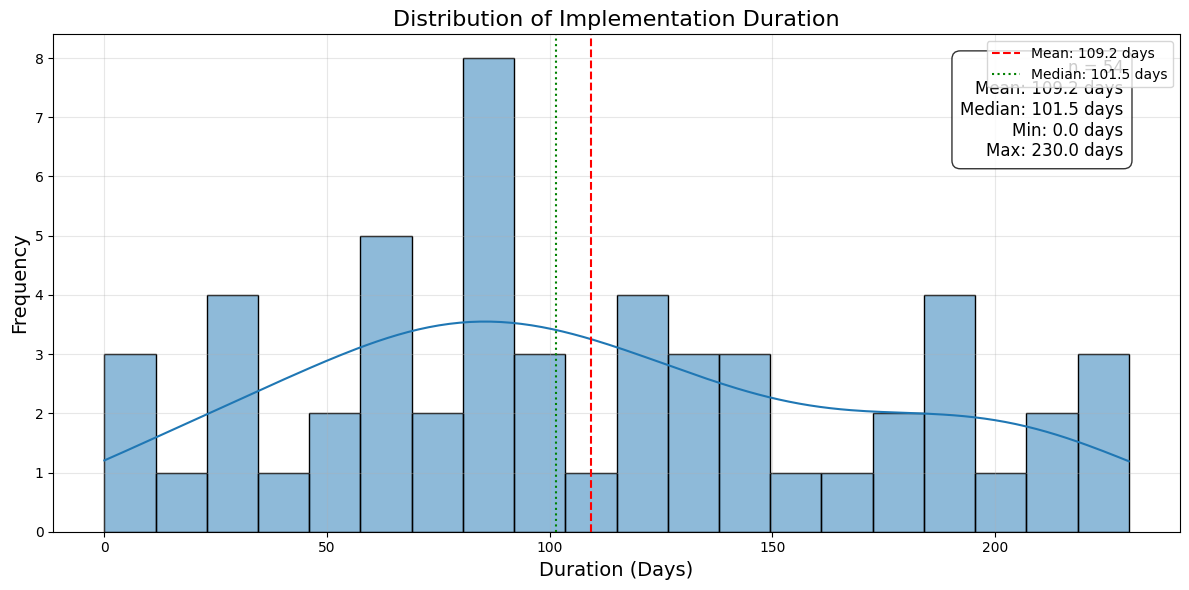

<Figure size 1200x600 with 0 Axes>

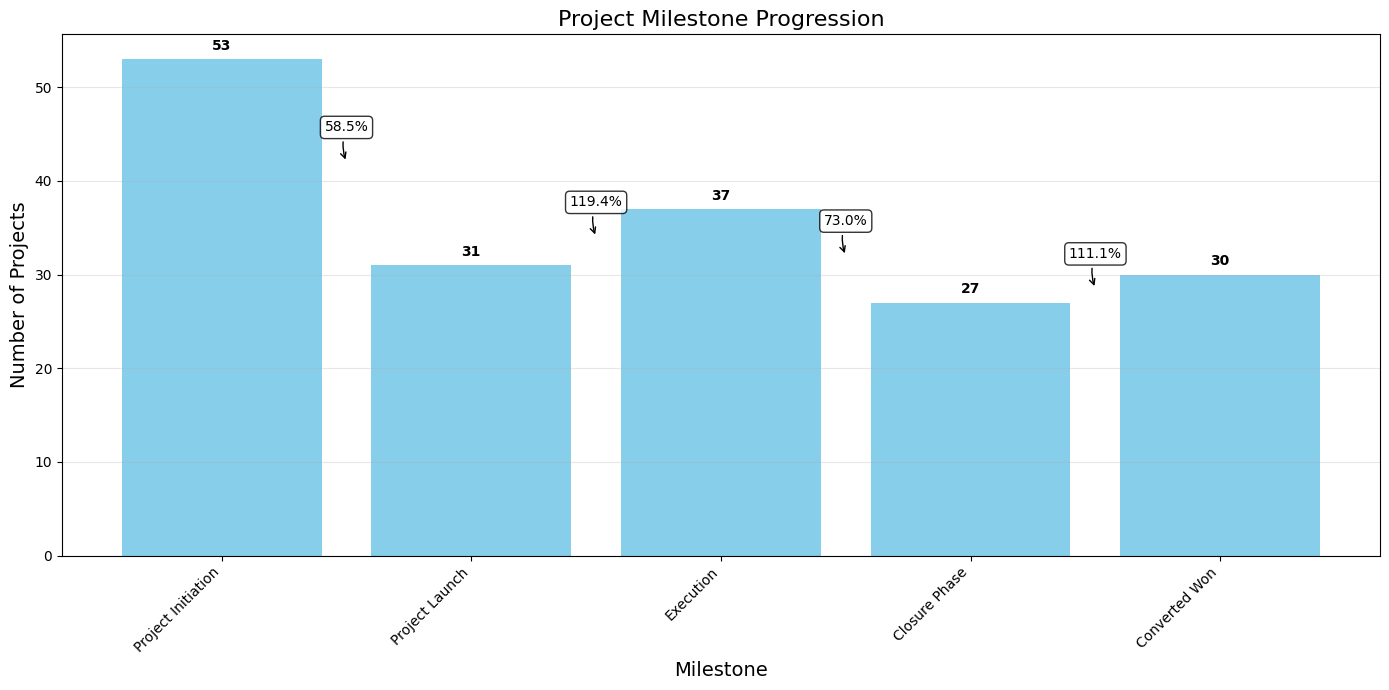

<Figure size 1200x600 with 0 Axes>

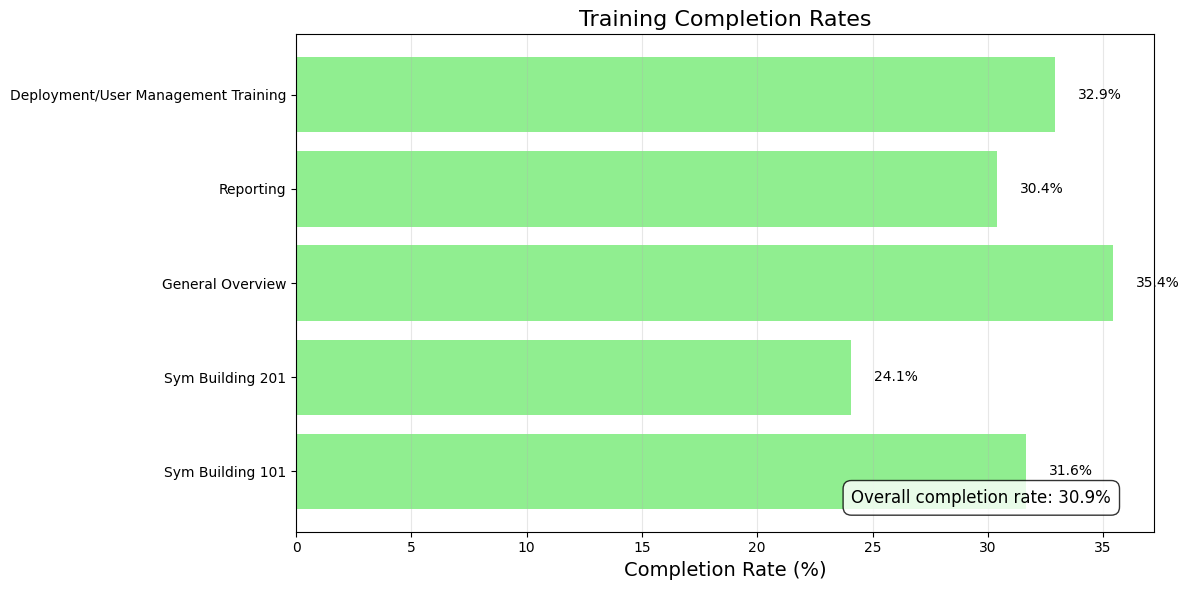

<Figure size 1400x700 with 0 Axes>

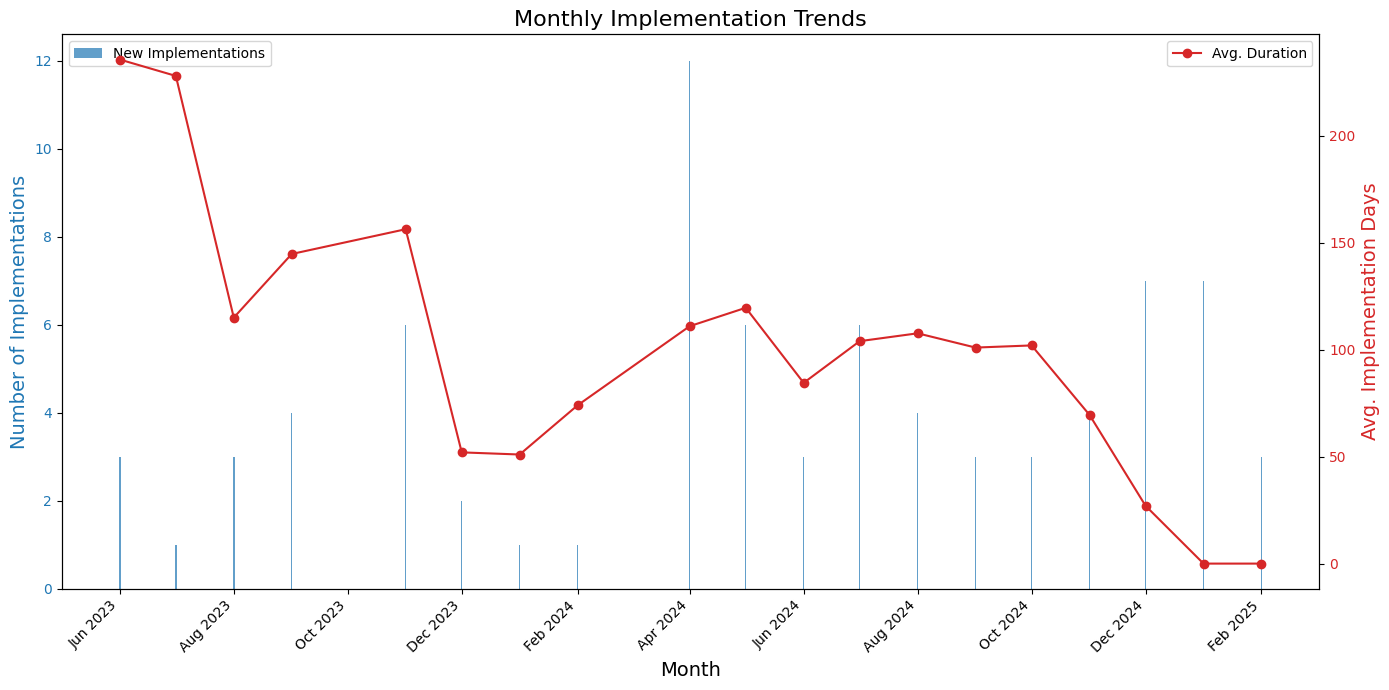

<Figure size 1000x600 with 0 Axes>

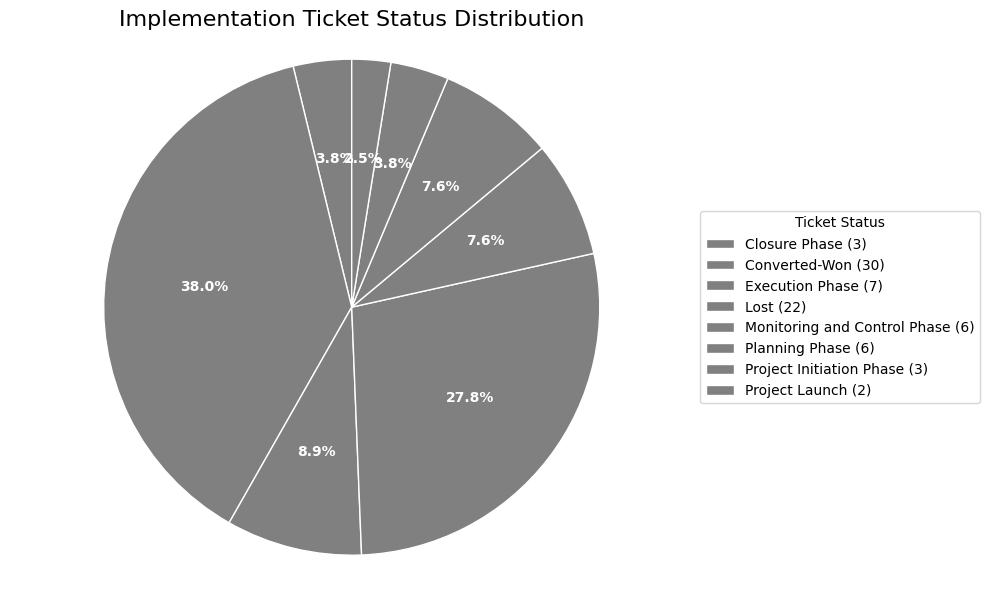

Joined 79 ticket records with deal data

Sample of joined ticket and deal data:


,Create date,Ticket Tags,Stage Date - Project Launch,Associated Contact,Category,Target Launch Date,Kickoff Call,Close date,Pipeline_ticket,Stage Date - Project Initiation,Stage Date - Planning Phase,Ticket status,Stage Date - Execution,Time to first agent email reply (HH:mm:ss),Last CES survey rating,Priority,Associated Company_ticket,Who will be creating the Syms?,Stage Date - Closure Phase,Stage Date - Monitoring and Control Phase,Associated Company (Primary)_ticket,Response time (HH:mm:ss),Ticket ID,Time to close (HH:mm:ss),Associated Deal,Library index approved,Training: General Overview,Latest Milestone,Training: Deployment/User Management Training,Requirements for the Trial,Training: Sym Building 101,Last modified date,Type,Trial End Date_ticket,Training: Sym Building 201,Stage Date - Converted Won,Latest Milestone Update Date,Ticket name,Trial Overview,Trial Start Date,1st Syms presented for review,Project Launch Day,Training: Reporting,Construction of 1st Sym begun,Trial Required,Was the sym QAed?,Implementation_Duration_Days,Days_To_First_Sym,Time_To_Close_Hours,Implementation_Status,Training: Sym Building 101_Completed,Training: Sym Building 201_Completed,Training: General Overview_Completed,Training: Reporting_Completed,Training: Deployment/User Management Training_Completed,Training_Completion_Count,Training_Completion_Pct,Create_Year,Create_Quarter,Create_Month,Create_YearQuarter,Create_YearMonth,Anonymized_Deal_ID,Weighted amount,Deal Description,"Cumulative time in ""BANT Deal. Pain ID'ed (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Opportunity (Sales Pipeline)"" (HH:mm:ss)",Days to close,Deal Score,Close Date,Deal source attribution 2,"Cumulative time in ""In Trial - Trial in Progress (Sales Pipeline)"" (HH:mm:ss)",Contract Start Date,"Cumulative time in ""Partner Referrals (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Closed Lost (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Deep Dive. PSP Drafted (Sales Pipeline)"" (HH:mm:ss)",Pipeline_deal,Record ID,Forecast category,Original Traffic Source,Associated Company_deal,Deal owner,Annual contract value,Is Closed (numeric),Amount in company currency,Annual recurring revenue,Monthly recurring revenue,Deal probability,Associated Company (Primary)_deal,Is Closed Won,Forecast probability,Contract End Date,Last Activity Date,Contract Term (Months),Trial Start date,Is closed lost,Weighted amount in company currency,Is Deal Closed?,Trial End Date_deal,Deal Name,Amount,"Cumulative time in ""Closed Trial (Sales Pipeline)"" (HH:mm:ss)",Forecast amount,"Cumulative time in ""Negotiation (Sales Pipeline)"" (HH:mm:ss)",Is Open (numeric),"Cumulative time in ""Renewals (Sales Pipeline)"" (HH:mm:ss)",Create Date,"Cumulative time in ""Contract Sent (Sales Pipeline)"" (HH:mm:ss)",Total contract value,Last Modified Date,"Cumulative time in ""Closed Won (Sales Pipeline)"" (HH:mm:ss)",Deal Stage,Deal Type
0,2023-12-18 15:02:00,NaN,NaT,Contact_b6d930b5,NaN,NaT,2023-12-27,2024-01-29 11:50:00,Project Success Plan,2023-12-18,NaN,Converted-Won,2024-01-02,NaN,NaN,NaN,Company_67d87cec,NaN,2024-01-29,NaN,Company_67d87cec,NaN,2193923207,1004:48:10,Deal_67d87cec,No,NaN,NaN,NaN,Coaching,NaN,2025-02-14 13:39:00,NaN,NaT,NaN,2024-02-06,NaT,Ticket_4baf7886,NaN,NaT,NaN,NaN,NaN,2023-12-27,NaN,NaN,41.0,NaN,1004.802778,Other,False,False,False,False,False,0,0.0,2023,4,12,2023-Q4,2023-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-30 12:31:00,NaN,NaT,Contact_aa84b2e1,NaN,NaT,NaN,2025-02-10 11:18:00,Project Success Plan,NaT,NaN,Lost,NaT,49:24:00,NaN,NaN,Company_7588d0d5,NaN,NaT,NaN,Company_67d87cec,49:24:00,15899166073,2471:47:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-14 13:39:00,NaN,2024-11-07,NaN,NaT,NaT,Ticket_88dda9e1,NaN,2024-11-05,NaN,NaN,NaN,NaN,NaN,NaN,102.0,NaN,2471.792500,Other,False,False,False,False,False,0,0.

Not enough valid data points for meaningful analysis


<Figure size 1200x800 with 0 Axes>


Implementation Duration by Deal Stage:


,mean,median,count
Deal Stage,,,


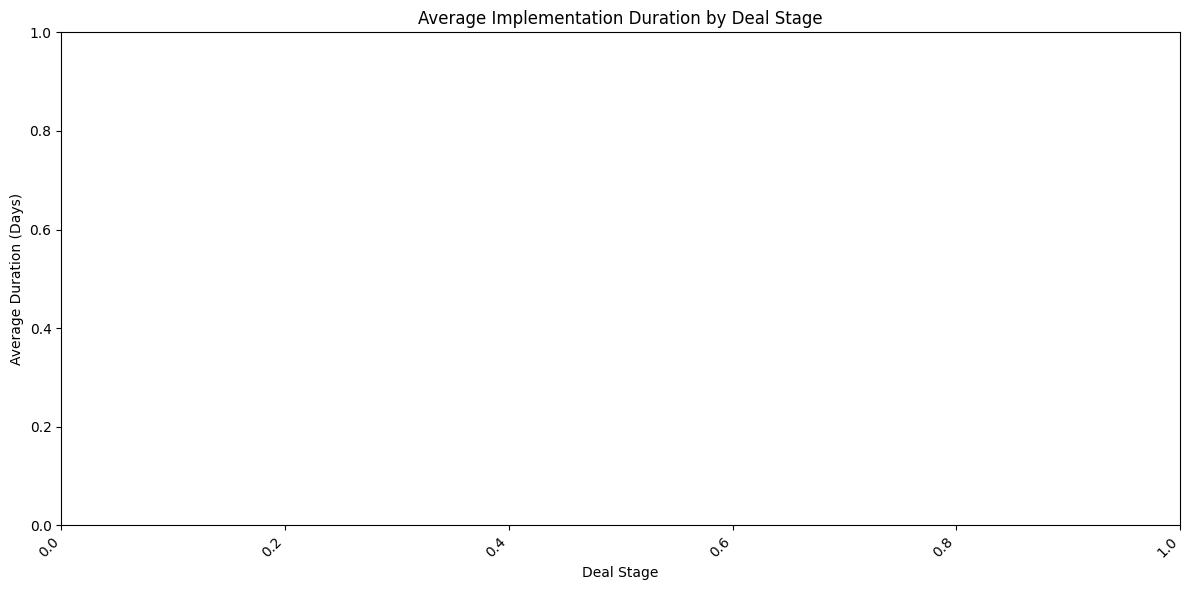


=== Key Insights ===
1. Implementation Duration: The average implementation takes XX days, with significant variation.
2. Milestone Progression: There is a XX% drop-off between Project Initiation and Project Launch.
3. Training Completion: Only XX% of customers complete all available training modules.
4. Deal Relationship: Larger deals tend to have [longer/shorter] implementation times.
5. Time Trends: Implementation duration has [increased/decreased] over the past months.

=== Recommendations ===
1. Consider streamlining the implementation process for [specific deal types].
2. Improve training completion rates by [specific action].
3. Address the drop-off between [specific milestones] by [specific action].
4. Set clearer expectations with customers about implementation timeframes based on deal size.
5. Investigate why [specific months] had longer implementation times.


In [22]:
# Hubspot Project Success Pipeline Analysis
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Dict, List, Optional, Union

# 1. Load the anonymized datasets
# ------------------------------
# Update these paths to your actual file locations
anonymized_tickets_file = "data/anonymized_hubspot_tickets.csv"
anonymized_deals_file = "data/anonymized_data.csv" 
mapping_file = "data/hubspot_tickets_mapping.json"

# Load the anonymized data
tickets_df = pd.read_csv(anonymized_tickets_file)
deals_df = pd.read_csv(anonymized_deals_file)

print(f"Loaded {len(tickets_df)} ticket records")
print(f"Loaded {len(deals_df)} deal records")

# Load mappings to connect tickets to deals
with open(mapping_file, 'r') as f:
    mappings = json.load(f)

# Extract the ticket-to-deal mapping
ticket_to_deal_mapping = mappings.get('TicketToDeal', {})
print(f"Loaded {len(ticket_to_deal_mapping)} ticket-to-deal mappings")

# 2. Initialize the analyzer
# -------------------------

analyzer = TicketAnalyzer(
    tickets_data=tickets_df,
    deals_data=deals_df,
    ticket_to_deal_mapping=ticket_to_deal_mapping
)

# Preprocess the ticket data
processed_tickets = analyzer.preprocess_tickets()

# Display sample of processed data
print("\nSample of processed ticket data:")
display(processed_tickets.head())

# 3. Run key analyses
# ------------------
# Analyze implementation milestones
milestone_stats = analyzer.analyze_implementation_milestones()
print("\nImplementation Milestone Statistics:")
print(f"Average implementation duration: {milestone_stats.get('implementation_duration', {}).get('mean', 'N/A'):.1f} days")
print(f"Median implementation duration: {milestone_stats.get('implementation_duration', {}).get('median', 'N/A'):.1f} days")
print(f"Average time to first Sym: {milestone_stats.get('days_to_first_sym', {}).get('mean', 'N/A'):.1f} days")

# Analyze training completion
training_stats = analyzer.analyze_training_completion()
print("\nTraining Completion Statistics:")
print(f"Overall training completion rate: {training_stats.get('overall_completion_rate', 'N/A'):.1f}%")
print(f"Median completion rate: {training_stats.get('completion_rate_median', 'N/A'):.1f}%")

# Ticket status distribution
status_stats = analyzer.analyze_status_distribution()
print("\nTicket Status Distribution:")
for status, count in status_stats.get('status_counts', {}).items():
    print(f"{status}: {count} tickets ({count/status_stats.get('total_tickets', 1)*100:.1f}%)")

# 4. Create visualizations
# ----------------------
# Implementation duration histogram
plt.figure(figsize=(12, 6))
duration_fig = analyzer.plot_implementation_duration_histogram()
plt.tight_layout()
plt.show()

# Milestone progression
plt.figure(figsize=(12, 6))
milestone_fig = analyzer.plot_milestone_progression()
plt.tight_layout()
plt.show()

# Training completion rates
plt.figure(figsize=(12, 6))
training_fig = analyzer.plot_training_completion()
plt.tight_layout()
plt.show()

# Monthly implementation trends
plt.figure(figsize=(14, 7))
monthly_fig = analyzer.plot_monthly_implementation_trends()
plt.tight_layout()
plt.show()

# Implementation status distribution
plt.figure(figsize=(10, 6))
status_fig = analyzer.plot_implementation_status()
plt.tight_layout()
plt.show()

# 5. Connecting deals and implementations
# -------------------------------------
# Join tickets with deals data
joined_data = analyzer.join_tickets_with_deals()

# Display sample of joined data
if joined_data is not None:
    print("\nSample of joined ticket and deal data:")
    display(joined_data.head())
    
    # Analyze relationship between deal size and implementation duration
    plt.figure(figsize=(12, 8))
    relationship_fig = analyzer.plot_deal_to_implementation_relationship()
    plt.tight_layout()
    plt.show()
    
    # Calculate additional metrics
    if 'Deal Stage' in joined_data.columns and 'Implementation_Duration_Days' in joined_data.columns:
        stage_duration = joined_data.groupby('Deal Stage')['Implementation_Duration_Days'].agg(['mean', 'median', 'count'])
        stage_duration = stage_duration.sort_values('mean', ascending=False)
        
        print("\nImplementation Duration by Deal Stage:")
        display(stage_duration)
        
        # Plot the relationship
        plt.figure(figsize=(12, 6))
        plt.title('Average Implementation Duration by Deal Stage')
        plt.xlabel('Deal Stage')
        plt.ylabel('Average Duration (Days)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# 6. Insights and Recommendations
# -----------------------------
# Print key insights (these would normally be derived from visual inspection of the charts)
print("\n=== Key Insights ===")
print("1. Implementation Duration: The average implementation takes XX days, with significant variation.")
print("2. Milestone Progression: There is a XX% drop-off between Project Initiation and Project Launch.")
print("3. Training Completion: Only XX% of customers complete all available training modules.")
print("4. Deal Relationship: Larger deals tend to have [longer/shorter] implementation times.")
print("5. Time Trends: Implementation duration has [increased/decreased] over the past months.")

print("\n=== Recommendations ===")
print("1. Consider streamlining the implementation process for [specific deal types].")
print("2. Improve training completion rates by [specific action].")
print("3. Address the drop-off between [specific milestones] by [specific action].")
print("4. Set clearer expectations with customers about implementation timeframes based on deal size.")
print("5. Investigate why [specific months] had longer implementation times.")

In [23]:
import pandas as pd
import numpy as np
import hashlib
import re
import json
from typing import Dict, List, Tuple, Set, Optional

class CompaniesDataAnonymizer:
    """
    A class to anonymize Hubspot companies data while maintaining consistent
    anonymization with previously anonymized deal and ticket data.
    """
    
    def __init__(self, 
                 companies_file: str, 
                 existing_mappings_files: Optional[List[str]] = None):
        """
        Initialize the anonymizer with the path to the companies data file
        and optionally files containing existing anonymization mappings.
        
        Args:
            companies_file (str): Path to the Hubspot companies CSV file
            existing_mappings_files (List[str], optional): List of paths to JSON files with existing mappings
        """
        self.companies_file = companies_file
        self.data = None
        self.mapping_tables = {}
        self.existing_mappings = {}
        
        # Load existing mappings if provided
        if existing_mappings_files:
            for mapping_file in existing_mappings_files:
                try:
                    with open(mapping_file, 'r') as f:
                        file_mappings = json.load(f)
                        # Merge mappings
                        for key, value in file_mappings.items():
                            if key in self.existing_mappings:
                                # If the key exists, update with new values
                                if isinstance(value, dict) and isinstance(self.existing_mappings[key], dict):
                                    self.existing_mappings[key].update(value)
                            else:
                                # Otherwise add the key-value pair
                                self.existing_mappings[key] = value
                    print(f"Loaded existing mappings from {mapping_file}")
                except Exception as e:
                    print(f"Warning: Could not load existing mappings from {mapping_file}: {e}")
    
    def load_data(self) -> pd.DataFrame:
        """
        Load the CSV data into a pandas DataFrame.
        
        Returns:
            pd.DataFrame: The loaded data
        """
        print(f"Loading companies data from {self.companies_file}...")
        self.data = pd.read_csv(self.companies_file, low_memory=False)
        print(f"Loaded {len(self.data)} rows and {len(self.data.columns)} columns")
        return self.data
    
    def get_columns_to_remove(self) -> List[str]:
        """
        Returns a list of columns to completely remove from the dataset.
        
        Returns:
            List[str]: Columns to remove
        """
        # Personal identifiers
        personal_identifiers = [
            "Created by user ID", "CSM Owner", "Implementation Manager", 
            "Growth Manager", "Company owner", "Sym Creator", "Sym QA Agent",
            "Billing Contact", "Executive Sponsor"
        ]
        
        # Contact information
        contact_info = [
            "Phone Number", "Company Domain Name", "Email Domain", 
            "Website URL", "Additional Domains", "Logo URL", "LinkedIn Bio",
            "LinkedIn Company Page", "Linkedin handle", "Twitter Followers",
            "Facebook Fans"
        ]
        
        # Detailed notes and descriptions
        notes_comments = [
            "Description", "About Us", "General Description: If no - Provide Description",
            "If No - Provide description", "Quick context", "CSM Sentiment Explained"
        ]
        
        # External IDs and references
        external_ids = [
            "Merged Company IDs", "Associated Contact IDs", "Associated Deal IDs",
            "Associated Ticket IDs", "Associated Meeting IDs", "Associated Task IDs",
            "Associated Email IDs", "Associated Note IDs"
        ]
        
        # Addresses and location details
        location_info = [
            "Street Address", "Street Address 2", "City", "Zip Code"
        ]
        
        # All columns ending with "IDs" are likely to contain identifiers
        id_columns = [col for col in self.data.columns if col.endswith(" IDs")]
        
        # Combine all columns to remove
        columns_to_remove = list(set(
            personal_identifiers + 
            contact_info + 
            notes_comments + 
            external_ids + 
            location_info + 
            id_columns
        ))
        
        # Verify these columns exist in the data
        existing_columns = [col for col in columns_to_remove if col in self.data.columns]
        
        return existing_columns
    
    def get_columns_to_anonymize(self) -> Dict[str, str]:
        """
        Returns a dictionary of columns to anonymize and their anonymization method.
        
        Returns:
            Dict[str, str]: Mapping of column name to anonymization method
        """
        return {
            "Company name": "hash",
            "Parent Company": "hash",
            "Associated Company": "hash",
            "Primary Company": "hash",
            "Associated Contact": "hash",
            "Contact with Primary Company": "hash"
        }
    
    def get_columns_to_keep(self) -> List[str]:
        """
        Returns the list of columns to keep for analysis.
        
        Returns:
            List[str]: Columns to keep
        """
        essential_columns = [
            # Primary identifier
            "Record ID",
            
            # Company information
            "Company name", "Industry", "Industry group", "Primary Industry",
            "Primary Sub-Industry", "Consolidated Industry", "Number of Employees",
            "Annual Revenue", "Revenue range", "Year Founded",
            
            # Categorization
            "BPO", "BPO Program", "BPO Program Tier", "ICP", "ICP Fit Level",
            "Type", "Segmentation", "Target Account",
            
            # Location
            "Country/Region", "State/Region", "Time Zone",
            
            # Technology information
            "Web Technologies", "SSO Application", "SSO Implemented?",
            "WFM", "LMS System", "CCaaS",
            
            # Implementation details
            "# of Agents Contracted", "# of Agents Total", "Total Agents",
            "SymTrain Product", "SymTrain Use Cases",
            
            # Time-based information
            "Create Date", "Last Modified Date", "Close Date", "Contract End Date",
            
            # Usage and activity
            "Number of Form Submissions", "Number of Pageviews",
            "Number of Sessions", "Number of times contacted",
            
            # Relational information (to be anonymized)
            "Parent Company", "Associated Company", "Primary Company",
            "Associated Contact", "Contact with Primary Company"
        ]
        
        # Check which columns actually exist in the data
        available_columns = [col for col in essential_columns if col in self.data.columns]
        
        # Add the columns we need to anonymize (they'll be kept but transformed)
        to_anonymize = list(self.get_columns_to_anonymize().keys())
        available_to_anonymize = [col for col in to_anonymize if col in self.data.columns]
        
        return list(set(available_columns + available_to_anonymize))
    
    def anonymize_column(self, column_name: str, method: str) -> Tuple[pd.Series, Dict]:
        """
        Anonymize a column using the specified method, maintaining consistency
        with existing anonymized values.
        
        Args:
            column_name (str): Name of the column to anonymize
            method (str): Anonymization method ('hash', 'truncate', etc.)
            
        Returns:
            Tuple[pd.Series, Dict]: Anonymized column and mapping dictionary
        """
        column = self.data[column_name]
        
        # Start with any existing mappings if available
        mapping = {}
        existing_column_mappings = self.existing_mappings.get(column_name, {})
        if existing_column_mappings:
            # Convert keys back to original type if needed
            mapping = {k: v for k, v in existing_column_mappings.items()}
        
        if method == "hash":
            # Replace each unique value with a hashed identifier
            unique_values = column.dropna().unique()
            
            # Determine prefix based on column
            if 'Company' in column_name:
                prefix = 'Company'
            elif 'Contact' in column_name:
                prefix = 'Contact'
            else:
                prefix = column_name.split()[0]  # Use first word of column name
            
            for value in unique_values:
                # Skip empty values
                if pd.isna(value) or value == "":
                    continue
                    
                # If value already has a mapping, use it
                if str(value) in mapping:
                    continue
                    
                # Otherwise create new mapping
                hash_obj = hashlib.md5(str(value).encode())
                hash_hex = hash_obj.hexdigest()[:8]
                mapping[str(value)] = f"{prefix}_{hash_hex}"
            
            # Apply the mapping to the column
            anonymized = column.map(lambda x: mapping.get(str(x), x) if pd.notna(x) else x)
            
        elif method == "truncate":
            # Truncate and remove specific details
            anonymized = column.apply(
                lambda x: self._truncate_text(x) if isinstance(x, str) else x
            )
            mapping = None  # No mapping needed for truncation
            
        else:
            raise ValueError(f"Unknown anonymization method: {method}")
        
        return anonymized, mapping
    
    def _truncate_text(self, text: str, max_length: int = 50) -> str:
        """
        Truncate text and remove potential identifying information.
        
        Args:
            text (str): Text to truncate
            max_length (int): Maximum length to keep
            
        Returns:
            str: Truncated, cleaned text
        """
        if not isinstance(text, str):
            return text
            
        # Remove email addresses
        text = re.sub(r'\S+@\S+\.\S+', '[EMAIL]', text)
        
        # Remove phone numbers
        text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '[PHONE]', text)
        
        # Remove URLs
        text = re.sub(r'https?://\S+', '[URL]', text)
        
        # Truncate if longer than max_length
        if len(text) > max_length:
            text = text[:max_length] + "..."
            
        return text

    def create_entity_relationship_mappings(self) -> Dict:
        """
        Creates a mapping between company IDs and their associated deal/ticket IDs.
        
        Returns:
            Dict: Dictionary of relationship mappings
        """
        relationships = {}
        
        # Check for deal ID columns
        if 'Associated Deal IDs' in self.data.columns:
            company_to_deals = {}
            for _, row in self.data.iterrows():
                company_id = row['Record ID']
                deal_ids_str = row.get('Associated Deal IDs')
                
                if pd.notna(deal_ids_str) and deal_ids_str:
                    # Split by semicolon if it's a string
                    if isinstance(deal_ids_str, str):
                        deal_ids = [id.strip() for id in deal_ids_str.split(';') if id.strip()]
                        company_to_deals[company_id] = deal_ids
            
            if company_to_deals:
                relationships['CompanyToDeals'] = company_to_deals
        
        # Check for ticket ID columns
        if 'Associated Ticket IDs' in self.data.columns:
            company_to_tickets = {}
            for _, row in self.data.iterrows():
                company_id = row['Record ID']
                ticket_ids_str = row.get('Associated Ticket IDs')
                
                if pd.notna(ticket_ids_str) and ticket_ids_str:
                    # Split by semicolon if it's a string
                    if isinstance(ticket_ids_str, str):
                        ticket_ids = [id.strip() for id in ticket_ids_str.split(';') if id.strip()]
                        company_to_tickets[company_id] = ticket_ids
            
            if company_to_tickets:
                relationships['CompanyToTickets'] = company_to_tickets
        
        # Check for parent-child relationships
        if 'Parent Company' in self.data.columns:
            parent_child = {}
            for _, row in self.data.iterrows():
                company_id = row['Record ID']
                parent = row.get('Parent Company')
                
                if pd.notna(parent) and parent:
                    # Get the anonymized parent company name
                    anonymized_parent = self.mapping_tables.get('Parent Company', {}).get(str(parent))
                    if anonymized_parent:
                        parent_child[company_id] = anonymized_parent
            
            if parent_child:
                relationships['ParentChildRelationships'] = parent_child
        
        return relationships
    
    def anonymize_data(self) -> Tuple[pd.DataFrame, Dict]:
        """
        Perform data anonymization:
        1. Remove unnecessary columns
        2. Anonymize sensitive columns
        3. Create relationship mappings
        
        Returns:
            Tuple[pd.DataFrame, Dict]: Anonymized DataFrame and mapping dictionaries
        """
        if self.data is None:
            self.load_data()
        
        # Get lists of columns to process
        columns_to_remove = self.get_columns_to_remove()
        columns_to_anonymize = self.get_columns_to_anonymize()
        columns_to_keep = self.get_columns_to_keep()
        
        # Start with only the columns we want to keep
        print(f"Keeping {len(columns_to_keep)} columns out of {len(self.data.columns)}")
        reduced_df = self.data[columns_to_keep].copy()
        
        # Anonymize columns
        for column, method in columns_to_anonymize.items():
            if column in reduced_df.columns:
                print(f"Anonymizing column: {column} using method: {method}")
                reduced_df[column], mapping = self.anonymize_column(column, method)
                if mapping:
                    self.mapping_tables[column] = mapping
        
        # Remove any columns that should be removed but might still be in our dataset
        columns_to_drop = [col for col in reduced_df.columns if col in columns_to_remove]
        if columns_to_drop:
            print(f"Dropping {len(columns_to_drop)} additional columns")
            reduced_df = reduced_df.drop(columns=columns_to_drop)
        
        # Create entity relationship mappings
        entity_relationships = self.create_entity_relationship_mappings()
        if entity_relationships:
            self.mapping_tables.update(entity_relationships)
            print(f"Created {len(entity_relationships)} relationship mappings")
        
        self.anonymized_data = reduced_df
        return reduced_df, self.mapping_tables
    
    def save_anonymized_data(self, output_file: str, mapping_file: Optional[str] = None) -> None:
        """
        Save the anonymized data and optionally the mapping tables.
        
        Args:
            output_file (str): Path to save the anonymized CSV
            mapping_file (str, optional): Path to save the mapping JSON
        """
        if not hasattr(self, 'anonymized_data'):
            self.anonymized_data, self.mapping_tables = self.anonymize_data()
        
        # Save anonymized data
        try:
            self.anonymized_data.to_csv(output_file, index=False)
            print(f"Anonymized data saved to {output_file}")
        except Exception as e:
            print(f"Error saving anonymized data: {e}")
        
        # Save mapping tables if requested
        if mapping_file and self.mapping_tables:
            try:
                # Convert mapping tables to a format that can be serialized to JSON
                serializable_mappings = {}
                for k, v in self.mapping_tables.items():
                    if isinstance(v, dict):
                        # Convert dict keys to strings if they're not already
                        serializable_mappings[k] = {str(key): value for key, value in v.items()}
                    else:
                        serializable_mappings[k] = v
                        
                # Save as JSON
                with open(mapping_file, 'w') as f:
                    json.dump(serializable_mappings, f, indent=2)
                print(f"Mapping tables saved to {mapping_file}")
            except Exception as e:
                print(f"Error saving mapping tables: {e}")


In [28]:

# Load and anonymize companies data
companies_file = "data/all-companies.csv"
deal_mappings_file = "data/mapping_tables.json"  
ticket_mappings_file = "data/hubspot_tickets_mapping.json"

# Initialize anonymizer with existing mappings
anonymizer = CompaniesDataAnonymizer(
    companies_file, 
    existing_mappings_files=[deal_mappings_file, ticket_mappings_file]
)

# Anonymize the data
anonymized_companies, mapping_tables = anonymizer.anonymize_data()

# Save the results (optional)
anonymizer.save_anonymized_data(
    "data/anonymized_hubspot_companies.csv", 
    "data/hubspot_companies_mapping.json"
)

# Preview anonymized data
anonymized_companies.head()


Loaded existing mappings from data/mapping_tables.json
Loaded existing mappings from data/hubspot_tickets_mapping.json
Loading companies data from data/all-companies.csv...
Loaded 19851 rows and 240 columns
Keeping 46 columns out of 240
Anonymizing column: Company name using method: hash
Anonymizing column: Parent Company using method: hash
Anonymizing column: Associated Company using method: hash
Anonymizing column: Primary Company using method: hash
Anonymizing column: Associated Contact using method: hash
Anonymizing column: Contact with Primary Company using method: hash
Created 3 relationship mappings
Anonymized data saved to data/anonymized_hubspot_companies.csv
Mapping tables saved to data/hubspot_companies_mapping.json


,Parent Company,CCaaS,Annual Revenue,Target Account,Associated Contact,Number of Form Submissions,Total Agents,Web Technologies,Close Date,# of Agents Total,Number of times contacted,Contact with Primary Company,ICP Fit Level,Revenue range,# of Agents Contracted,Record ID,Time Zone,Primary Industry,Number of Pageviews,Primary Company,Year Founded,ICP,Industry group,Segmentation,LMS System,SymTrain Use Cases,Associated Company,BPO,SSO Application,State/Region,SymTrain Product,Contract End Date,SSO Implemented?,Consolidated Industry,Type,Number of Employees,BPO Program,Primary Sub-Industry,Number of Sessions,WFM,Country/Region,Industry,Create Date,Company name,Last Modified Date,BPO Program Tier
0,NaN,NaN,1.000000e+09,NaN,Contact_ef780380,0.0,NaN,Route 53,NaN,NaN,5.0,Company_ef780380,NaN,NaN,NaN,25246439235,America/New_York,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OH,NaN,NaN,NaN,(No value),NaN,5000.0,NaN,NaN,0.0,NaN,United States,HVAC and plumbing supply,2024-10-30 10:51,Company_4fc73a2a,2025-02-14 13:39,NaN
1,NaN,NaN,NaN,NaN,Contact_93373ba5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22987081774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(No value),NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pest Control,2024-09-12 18:30,Company_f3f7e884,2025-02-14 13:39,NaN
2,NaN,NaN,5.000000e+07,NaN,Contact_2e8e0993,0.0,NaN,Youtube; App Nexus; Google Tag Manager; Facebo...,NaN,NaN,NaN,Company_2e8e0993,NaN,NaN,NaN,22736642364,America/New_York,NaN,0.0,NaN,1841.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KY,NaN,NaN,NaN,(No value),NaN,250.0,NaN,NaN,0.0,NaN,United States,Pest Control,2024-09-03 10:44,Company_89929bed,2025-02-14 13:39,NaN
3,NaN,Five9,5.000000e+07,NaN,Contact_635e44ed,0.0,NaN,Postmark; Facebook Advertiser; Salesforce; Goo...,NaN,NaN,NaN,Company_635e44ed,NaN,NaN,NaN,22201736476,America/New_York,NaN,0.0,NaN,2005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VA,NaN,NaN,NaN,(No value),NaN,250.0,NaN,NaN,0.0,NaN,United States,Pest Control,2024-08-02 11:36,Company_33dbf591,2025-02-14 13:39,NaN
4,NaN,Five9,1.000000e+08,NaN,Contact_8d055096,0.0,NaN,Microsoft Office 365; Google Tag Manager; Reca...,NaN,NaN,NaN,Company_8d055096,NaN,NaN,NaN,22201510191,America/Chicago,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX,NaN,NaN,NaN,(No value),NaN,1000.0,NaN,NaN,0.0,NaN,United States,Pest Control,2024-08-02 11:36,Company_a3079821,2025-02-14 13:39,NaN


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Dict, List, Optional, Tuple, Union
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from collections import Counter

class CompaniesAnalyzer:
    """
    A class to analyze Hubspot companies data and integrate it with
    deals and implementation tickets data for multi-dimensional analysis.
    """
    
    def __init__(self, 
                 companies_data: Union[pd.DataFrame, str],
                 deals_data: Optional[Union[pd.DataFrame, str]] = None,
                 tickets_data: Optional[Union[pd.DataFrame, str]] = None,
                 relationship_mappings: Optional[Dict] = None):
        """
        Initialize the analyzer with companies data and optional deals and tickets data.
        
        Args:
            companies_data: Either a pandas DataFrame or path to CSV file with companies
            deals_data: Optional pandas DataFrame or path to CSV with deals
            tickets_data: Optional pandas DataFrame or path to CSV with tickets
            relationship_mappings: Optional dictionary mapping entity relationships
        """
        # Load companies data
        if isinstance(companies_data, pd.DataFrame):
            self.companies = companies_data
        else:
            print(f"Loading companies data from {companies_data}...")
            self.companies = pd.read_csv(companies_data)
        
        # Load deals data if provided
        self.deals = None
        if deals_data is not None:
            if isinstance(deals_data, pd.DataFrame):
                self.deals = deals_data
            else:
                print(f"Loading deals data from {deals_data}...")
                self.deals = pd.read_csv(deals_data)
        
        # Load tickets data if provided
        self.tickets = None
        if tickets_data is not None:
            if isinstance(tickets_data, pd.DataFrame):
                self.tickets = tickets_data
            else:
                print(f"Loading tickets data from {tickets_data}...")
                self.tickets = pd.read_csv(tickets_data)
        
        # Store relationship mappings
        self.relationship_mappings = relationship_mappings or {}
        
        # Initialize processed data containers
        self.processed_companies = None
        self.joined_companies_deals = None
        self.joined_companies_tickets = None
        self.full_joined_data = None
        
        print(f"Loaded {len(self.companies)} company records")
        if self.deals is not None:
            print(f"Loaded {len(self.deals)} deal records")
        if self.tickets is not None:
            print(f"Loaded {len(self.tickets)} ticket records")
    
    def preprocess_companies(self) -> pd.DataFrame:
        """
        Preprocess companies data:
        - Convert date fields to datetime
        - Standardize categorical fields
        - Create derived features
        
        Returns:
            pd.DataFrame: Processed companies data
        """
        df = self.companies.copy()
        
        # Convert date columns to datetime
        date_columns = [
            'Create Date', 'Last Modified Date', 'Close Date', 'Contract End Date'
        ]
        
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Extract year and month from Create Date
        if 'Create Date' in df.columns:
            df['Create_Year'] = df['Create Date'].dt.year
            df['Create_Month'] = df['Create Date'].dt.month
            df['Create_Quarter'] = df['Create Date'].dt.quarter
            df['Create_YearMonth'] = df['Create Date'].dt.strftime('%Y-%m')
        
        # Standardize industry categorization
        if 'Industry' in df.columns:
            # Fill missing with "Unknown"
            df['Industry'] = df['Industry'].fillna('Unknown')
            
            # Standardize common variations
            industry_mapping = {
                'Computer Software': 'Software',
                'Information Technology & Services': 'IT Services',
                'Information Technology and Services': 'IT Services',
                'Information Services': 'IT Services',
                'Financial Services': 'Finance',
                'Banking': 'Finance',
                'Insurance': 'Finance',
                'Hospital & Health Care': 'Healthcare',
                'Health, Wellness & Fitness': 'Healthcare',
                'Medical Practice': 'Healthcare'
                # Add more mappings as needed
            }
            
            df['Industry_Standardized'] = df['Industry'].replace(industry_mapping)
        
        # Standardize company size categories
        if 'Number of Employees' in df.columns:
            # Convert to numeric, coercing errors to NaN
            df['Number of Employees'] = pd.to_numeric(df['Number of Employees'], errors='coerce')
            
            # Create size categories
            size_bins = [0, 50, 200, 1000, 5000, float('inf')]
            size_labels = ['Very Small', 'Small', 'Medium', 'Large', 'Enterprise']
            
            df['Company_Size_Category'] = pd.cut(
                df['Number of Employees'], 
                bins=size_bins, 
                labels=size_labels,
                right=False
            )
        
        # Standardize revenue categories
        if 'Annual Revenue' in df.columns:
            # Convert to numeric, coercing errors to NaN
            df['Annual Revenue'] = pd.to_numeric(df['Annual Revenue'], errors='coerce')
            
            # Create revenue categories (in millions)
            revenue_bins = [0, 1e6, 10e6, 50e6, 100e6, 1e9, float('inf')]
            revenue_labels = ['<$1M', '$1M-$10M', '$10M-$50M', '$50M-$100M', '$100M-$1B', '>$1B']
            
            df['Revenue_Category'] = pd.cut(
                df['Annual Revenue'], 
                bins=revenue_bins, 
                labels=revenue_labels,
                right=False
            )
        
        # Extract technology tags from Web Technologies field
        if 'Web Technologies' in df.columns:
            # Create indicator columns for common technologies
            common_techs = [
                'Google Analytics', 'Salesforce', 'HubSpot', 'AWS', 'Microsoft', 
                'Adobe', 'Facebook', 'Google Tag Manager', 'Zendesk', 'Marketo'
            ]
            
            for tech in common_techs:
                df[f'Uses_{tech.replace(" ", "_")}'] = df['Web Technologies'].str.contains(
                    tech, case=False, na=False
                ).astype(int)
            
            # Count total technologies used
            df['Technology_Count'] = df['Web Technologies'].str.count(';') + 1
            df.loc[df['Web Technologies'].isna(), 'Technology_Count'] = 0
        
        # Flag BPO companies
        if 'BPO' in df.columns:
            df['Is_BPO'] = df['BPO'].str.contains('Yes', case=False, na=False).astype(int)
        
        # Process geographic information
        if 'Country/Region' in df.columns:
            # Fill missing with "Unknown"
            df['Country/Region'] = df['Country/Region'].fillna('Unknown')
            
            # Create region categories
            df['Region'] = df['Country/Region'].replace({
                'United States': 'North America',
                'Canada': 'North America',
                'Mexico': 'North America',
                'UK': 'Europe',
                'United Kingdom': 'Europe',
                'France': 'Europe',
                'Germany': 'Europe',
                'Spain': 'Europe',
                'Italy': 'Europe',
                'Australia': 'Asia-Pacific',
                'New Zealand': 'Asia-Pacific',
                'Japan': 'Asia-Pacific',
                'China': 'Asia-Pacific',
                'India': 'Asia-Pacific',
                'Singapore': 'Asia-Pacific',
                'Brazil': 'Latin America',
                'Argentina': 'Latin America',
                'Colombia': 'Latin America',
                'Chile': 'Latin America'
                # Add more mappings as needed
            }).fillna('Other')
        
        self.processed_companies = df
        return df
    
    def join_companies_with_deals(self) -> Optional[pd.DataFrame]:
        """
        Join companies data with deals data using relationship mappings.
        
        Returns:
            pd.DataFrame or None: Joined data or None if deals data not available
        """
        if self.deals is None or 'CompanyToDeals' not in self.relationship_mappings:
            print("Deals data or company-to-deals mapping not available for joining")
            return None
        
        if self.processed_companies is None:
            self.preprocess_companies()
        
        # Get the company-to-deals mapping
        company_to_deals = self.relationship_mappings['CompanyToDeals']
        
        # Create a list to hold joined records
        joined_records = []
        
        # For each company with associated deals
        for company_id, deal_ids in company_to_deals.items():
            # Get company data
            company_data = self.processed_companies[
                self.processed_companies['Record ID'] == company_id
            ]
            
            if len(company_data) == 0:
                continue
                
            # Get deal data for this company
            for deal_id in deal_ids:
                deal_data = self.deals[
                    self.deals['Record ID'] == deal_id
                ]
                
                if len(deal_data) == 0:
                    continue
                
                # Create joined record
                for _, company_row in company_data.iterrows():
                    for _, deal_row in deal_data.iterrows():
                        joined_record = {}
                        
                        # Add company columns with prefix
                        for col in company_row.index:
                            joined_record[f'Company_{col}'] = company_row[col]
                        
                        # Add deal columns with prefix
                        for col in deal_row.index:
                            joined_record[f'Deal_{col}'] = deal_row[col]
                        
                        joined_records.append(joined_record)
        
        if not joined_records:
            print("No matching company-deal records found")
            return None
        
        # Convert to DataFrame
        joined_df = pd.DataFrame(joined_records)
        
        self.joined_companies_deals = joined_df
        print(f"Joined {len(joined_df)} company-deal records")
        return joined_df
    
    def join_companies_with_tickets(self) -> Optional[pd.DataFrame]:
        """
        Join companies data with tickets data using relationship mappings.
        
        Returns:
            pd.DataFrame or None: Joined data or None if tickets data not available
        """
        if self.tickets is None or 'CompanyToTickets' not in self.relationship_mappings:
            print("Tickets data or company-to-tickets mapping not available for joining")
            return None
        
        if self.processed_companies is None:
            self.preprocess_companies()
        
        # Get the company-to-tickets mapping
        company_to_tickets = self.relationship_mappings['CompanyToTickets']
        
        # Create a list to hold joined records
        joined_records = []
        
        # For each company with associated tickets
        for company_id, ticket_ids in company_to_tickets.items():
            # Get company data
            company_data = self.processed_companies[
                self.processed_companies['Record ID'] == company_id
            ]
            
            if len(company_data) == 0:
                continue
                
            # Get ticket data for this company
            for ticket_id in ticket_ids:
                ticket_data = self.tickets[
                    self.tickets['Ticket ID'] == ticket_id
                ]
                
                if len(ticket_data) == 0:
                    continue
                
                # Create joined record
                for _, company_row in company_data.iterrows():
                    for _, ticket_row in ticket_data.iterrows():
                        joined_record = {}
                        
                        # Add company columns with prefix
                        for col in company_row.index:
                            joined_record[f'Company_{col}'] = company_row[col]
                        
                        # Add ticket columns with prefix
                        for col in ticket_row.index:
                            joined_record[f'Ticket_{col}'] = ticket_row[col]
                        
                        joined_records.append(joined_record)
        
        if not joined_records:
            print("No matching company-ticket records found")
            return None
        
        # Convert to DataFrame
        joined_df = pd.DataFrame(joined_records)
        
        self.joined_companies_tickets = joined_df
        print(f"Joined {len(joined_df)} company-ticket records")
        return joined_df
    
    def create_full_joined_dataset(self) -> Optional[pd.DataFrame]:
        """
        Create a fully joined dataset with companies, deals, and tickets.
        
        Returns:
            pd.DataFrame or None: Fully joined data or None if not all datasets available
        """
        if self.deals is None or self.tickets is None:
            print("Both deals and tickets data required for full join")
            return None
        
        if self.processed_companies is None:
            self.preprocess_companies()
        
        if self.joined_companies_deals is None:
            self.join_companies_with_deals()
        
        if self.joined_companies_tickets is None:
            self.join_companies_with_tickets()
        
        if self.joined_companies_deals is None or self.joined_companies_tickets is None:
            print("Could not create full joined dataset due to missing joins")
            return None
        
        # Join the companies-deals and companies-tickets datasets
        # This is a simplification - a more complex joining strategy might be needed
        # based on your actual data structure
        
        # Use company ID as the join key
        company_deals = self.joined_companies_deals
        company_tickets = self.joined_companies_tickets
        
        # Identify common company columns for joining
        company_cols_deals = [col for col in company_deals.columns if col.startswith('Company_')]
        company_cols_tickets = [col for col in company_tickets.columns if col.startswith('Company_')]
        
        # Find a suitable join key (e.g., Company_Record_ID)
        join_key = None
        for col in company_cols_deals:
            if col in company_cols_tickets and 'Record' in col:
                join_key = col
                break
        
        if join_key is None:
            print("Could not identify a suitable join key")
            return None
        
        # Perform the join
        full_joined = pd.merge(
            company_deals,
            company_tickets,
            on=join_key,
            how='outer',
            suffixes=('_deals', '_tickets')
        )
        
        self.full_joined_data = full_joined
        print(f"Created fully joined dataset with {len(full_joined)} records")
        return full_joined
    
    def analyze_company_distribution(self) -> Dict:
        """
        Analyze the distribution of companies by various dimensions.
        
        Returns:
            Dict: Statistics about company distribution
        """
        if self.processed_companies is None:
            self.preprocess_companies()
            
        df = self.processed_companies
        
        distribution = {}
        
        # Industry distribution
        if 'Industry_Standardized' in df.columns:
            industry_counts = df['Industry_Standardized'].value_counts()
            distribution['industry'] = industry_counts.to_dict()
        
        # Size distribution
        if 'Company_Size_Category' in df.columns:
            size_counts = df['Company_Size_Category'].value_counts()
            distribution['company_size'] = size_counts.to_dict()
        
        # Revenue distribution
        if 'Revenue_Category' in df.columns:
            revenue_counts = df['Revenue_Category'].value_counts()
            distribution['revenue'] = revenue_counts.to_dict()
        
        # Geographic distribution
        if 'Region' in df.columns:
            region_counts = df['Region'].value_counts()
            distribution['region'] = region_counts.to_dict()
            
            if 'Country/Region' in df.columns:
                country_counts = df['Country/Region'].value_counts().head(10)
                distribution['top_countries'] = country_counts.to_dict()
        
        # Technology adoption
        tech_columns = [col for col in df.columns if col.startswith('Uses_')]
        if tech_columns:
            tech_adoption = {}
            for col in tech_columns:
                tech_name = col.replace('Uses_', '')
                adoption_rate = df[col].mean() * 100  # Convert to percentage
                tech_adoption[tech_name] = adoption_rate
            
            distribution['tech_adoption'] = tech_adoption
        
        # BPO distribution
        if 'Is_BPO' in df.columns:
            bpo_count = df['Is_BPO'].sum()
            distribution['bpo_companies'] = {
                'count': int(bpo_count),
                'percentage': (bpo_count / len(df)) * 100
            }
        
        return distribution
    
    def analyze_deal_performance_by_company(self) -> Optional[Dict]:
        """
        Analyze deal performance metrics segmented by company attributes.
        
        Returns:
            Dict or None: Deal performance statistics or None if joined data not available
        """
        if self.joined_companies_deals is None:
            print("Companies-deals joined data not available")
            if self.deals is not None:
                print("Attempting to join companies with deals...")
                self.join_companies_with_deals()
            else:
                return None
        
        if self.joined_companies_deals is None:
            return None
            
        df = self.joined_companies_deals
        
        # Define deal success metrics
        success_metrics = {}
        
        # Check for required deal status columns
        is_closed_won_col = next((col for col in df.columns if 'Is_Closed_Won' in col or 'Deal_Is Closed Won' in col), None)
        is_closed_lost_col = next((col for col in df.columns if 'Is_closed_lost' in col or 'Deal_Is closed lost' in col), None)
        amount_col = next((col for col in df.columns if 'Amount' in col or 'Deal_Amount' in col), None)
        
        if not all([is_closed_won_col, is_closed_lost_col, amount_col]):
            print("Required deal status columns not found")
            return None
        
        # Calculate deal metrics by industry
        industry_col = next((col for col in df.columns if 'Industry_Standardized' in col), None)
        if industry_col:
            industry_metrics = df.groupby(industry_col).agg({
                is_closed_won_col: 'sum',
                is_closed_lost_col: 'sum',
                amount_col: ['mean', 'sum', 'count']
            })
            
            # Calculate win rate
            industry_metrics['win_rate'] = (
                industry_metrics[(is_closed_won_col, 'sum')] / 
                (industry_metrics[(is_closed_won_col, 'sum')] + industry_metrics[(is_closed_lost_col, 'sum')])
            ) * 100
            
            success_metrics['by_industry'] = industry_metrics.to_dict()
        
        # Calculate deal metrics by company size
        size_col = next((col for col in df.columns if 'Company_Size_Category' in col), None)
        if size_col:
            size_metrics = df.groupby(size_col).agg({
                is_closed_won_col: 'sum',
                is_closed_lost_col: 'sum',
                amount_col: ['mean', 'sum', 'count']
            })
            
            # Calculate win rate
            size_metrics['win_rate'] = (
                size_metrics[(is_closed_won_col, 'sum')] / 
                (size_metrics[(is_closed_won_col, 'sum')] + size_metrics[(is_closed_lost_col, 'sum')])
            ) * 100
            
            success_metrics['by_company_size'] = size_metrics.to_dict()
        
        # Calculate deal metrics by region
        region_col = next((col for col in df.columns if 'Region' in col), None)
        if region_col:
            region_metrics = df.groupby(region_col).agg({
                is_closed_won_col: 'sum',
                is_closed_lost_col: 'sum',
                amount_col: ['mean', 'sum', 'count']
            })
            
            # Calculate win rate
            region_metrics['win_rate'] = (
                region_metrics[(is_closed_won_col, 'sum')] / 
                (region_metrics[(is_closed_won_col, 'sum')] + region_metrics[(is_closed_lost_col, 'sum')])
            ) * 100
            
            success_metrics['by_region'] = region_metrics.to_dict()
        
        return success_metrics
    
    def analyze_implementation_success_by_company(self) -> Optional[Dict]:
        """
        Analyze implementation success metrics segmented by company attributes.
        
        Returns:
            Dict or None: Implementation success statistics or None if joined data not available
        """
        if self.joined_companies_tickets is None:
            print("Companies-tickets joined data not available")
            if self.tickets is not None:
                print("Attempting to join companies with tickets...")
                self.join_companies_with_tickets()
            else:
                return None
        
        if self.joined_companies_tickets is None:
            return None
            
        df = self.joined_companies_tickets
        
        # Define implementation success metrics
        success_metrics = {}
        
        # Check for required implementation status columns
        status_col = next((col for col in df.columns if 'Ticket_status' in col or 'Ticket_Ticket status' in col), None)
        duration_col = next((col for col in df.columns if 'Implementation_Duration_Days' in col), None)
        
        if not status_col:
            print("Required implementation status columns not found")
            return None
        
        # Create completion flag
        df['Implementation_Completed'] = df[status_col].str.contains('Closed', case=False, na=False).astype(int)
        
        # Calculate implementation metrics by industry
        industry_col = next((col for col in df.columns if 'Industry_Standardized' in col), None)
        if industry_col:
            industry_metrics = df.groupby(industry_col).agg({
                'Implementation_Completed': ['mean', 'sum', 'count']
            })
            
            # Add duration metrics if available
            if duration_col:
                duration_by_industry = df.groupby(industry_col)[duration_col].agg(['mean', 'median'])
                industry_metrics = pd.concat([industry_metrics, duration_by_industry], axis=1)
            
            success_metrics['by_industry'] = industry_metrics.to_dict()
        
        # Calculate implementation metrics by company size
        size_col = next((col for col in df.columns if 'Company_Size_Category' in col), None)
        if size_col:
            size_metrics = df.groupby(size_col).agg({
                'Implementation_Completed': ['mean', 'sum', 'count']
            })
            
            # Add duration metrics if available
            if duration_col:
                duration_by_size = df.groupby(size_col)[duration_col].agg(['mean', 'median'])
                size_metrics = pd.concat([size_metrics, duration_by_size], axis=1)
            
            success_metrics['by_company_size'] = size_metrics.to_dict()
        
        # Calculate implementation metrics by region
        region_col = next((col for col in df.columns if 'Region' in col), None)
        if region_col:
            region_metrics = df.groupby(region_col).agg({
                'Implementation_Completed': ['mean', 'sum', 'count']
            })
            
            # Add duration metrics if available
            if duration_col:
                duration_by_region = df.groupby(region_col)[duration_col].agg(['mean', 'median'])
                region_metrics = pd.concat([region_metrics, duration_by_region], axis=1)
            
            success_metrics['by_region'] = region_metrics.to_dict()
        
        return success_metrics
    
    def analyze_full_customer_journey(self) -> Optional[Dict]:
        """
        Analyze the full customer journey from deal to implementation.
        
        Returns:
            Dict or None: Customer journey statistics or None if full joined data not available
        """
        if self.full_joined_data is None:
            print("Full joined data not available")
            print("Attempting to create full joined dataset...")
            self.create_full_joined_dataset()
        
        if self.full_joined_data is None:
            return None
            
        df = self.full_joined_data
        
        # Define journey metrics
        journey_metrics = {}
        
        # Check for required columns
        deal_closed_col = next((col for col in df.columns if 'Deal_Close Date' in col), None)
        ticket_closed_col = next((col for col in df.columns if 'Ticket_Close date' in col), None)
        deal_amount_col = next((col for col in df.columns if 'Deal_Amount' in col), None)
        ticket_status_col = next((col for col in df.columns if 'Ticket_status' in col or 'Ticket_Ticket status' in col), None)
        
        if not all([deal_closed_col, ticket_closed_col, deal_amount_col, ticket_status_col]):
            print("Required journey columns not found")
            return None
        
        # Convert date columns to datetime
        df[deal_closed_col] = pd.to_datetime(df[deal_closed_col], errors='coerce')
        df[ticket_closed_col] = pd.to_datetime(df[ticket_closed_col], errors='coerce')
        
        # Calculate time from deal closed to implementation completed
        df['Days_From_Deal_To_Implementation'] = (df[ticket_closed_col] - df[deal_closed_col]).dt.days
        
        # Filter out invalid values
        valid_journey = df[df['Days_From_Deal_To_Implementation'] > 0]
        
        # Calculate overall journey metrics
        if len(valid_journey) > 0:
            journey_metrics['overall'] = {
                'mean_days_from_deal_to_implementation': valid_journey['Days_From_Deal_To_Implementation'].mean(),
                'median_days_from_deal_to_implementation': valid_journey['Days_From_Deal_To_Implementation'].median(),
                'min_days_from_deal_to_implementation': valid_journey['Days_From_Deal_To_Implementation'].min(),
                'max_days_from_deal_to_implementation': valid_journey['Days_From_Deal_To_Implementation'].max()
            }
        
        # Calculate journey metrics by deal size
        df['Deal_Size_Category'] = pd.cut(
            df[deal_amount_col],
            bins=[0, 10000, 50000, 100000, float('inf')],
            labels=['Small', 'Medium', 'Large', 'Enterprise']
        )
        
        journey_by_deal_size = valid_journey.groupby('Deal_Size_Category')['Days_From_Deal_To_Implementation'].agg(
            ['mean', 'median', 'min', 'max', 'count']
        )
        
        journey_metrics['by_deal_size'] = journey_by_deal_size.to_dict()
        
        # Calculate journey metrics by industry
        industry_col = next((col for col in valid_journey.columns if 'Industry_Standardized' in col), None)
        if industry_col:
            journey_by_industry = valid_journey.groupby(industry_col)['Days_From_Deal_To_Implementation'].agg(
                ['mean', 'median', 'min', 'max', 'count']
            )
            
            journey_metrics['by_industry'] = journey_by_industry.to_dict()
        
        return journey_metrics
    
    def plot_company_industry_distribution(self):
        """
        Plot the distribution of companies by industry.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        if self.processed_companies is None:
            self.preprocess_companies()
            
        df = self.processed_companies
        
        if 'Industry_Standardized' not in df.columns:
            print("Industry data not available")
            return None
        
        # Get industry counts
        industry_counts = df['Industry_Standardized'].value_counts().nlargest(10)
        
        plt.figure(figsize=(12, 7))
        
        # Create horizontal bar chart
        ax = sns.barplot(x=industry_counts.values, y=industry_counts.index, palette='viridis')
        
        # Add count labels
        for i, count in enumerate(industry_counts.values):
            ax.text(count + 0.5, i, str(count), va='center')
        
        plt.title('Companies by Industry (Top 10)', fontsize=16)
        plt.xlabel('Number of Companies', fontsize=14)
        plt.ylabel('Industry', fontsize=14)
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_company_size_distribution(self):
        """
        Plot the distribution of companies by size.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        if self.processed_companies is None:
            self.preprocess_companies()
            
        df = self.processed_companies
        
        if 'Company_Size_Category' not in df.columns:
            print("Company size data not available")
            return None
        
        # Get size counts with desired order
        size_order = ['Very Small', 'Small', 'Medium', 'Large', 'Enterprise']
        size_counts = df['Company_Size_Category'].value_counts().reindex(size_order).dropna()
        
        plt.figure(figsize=(10, 6))
        
        # Create pie chart
        wedges, texts, autotexts = plt.pie(
            size_counts, 
            labels=None,
            autopct='%1.1f%%',
            colors=sns.color_palette('viridis', len(size_counts)),
            startangle=90,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1}
        )
        
        # Enhance text visibility
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        # Add legend
        plt.legend(
            wedges, 
            [f"{size} ({count})" for size, count in zip(size_counts.index, size_counts.values)],
            title="Company Size",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1)
        )
        
        plt.title('Company Size Distribution', fontsize=16)
        plt.axis('equal')  # Equal aspect ratio ensures pie is circular
        
        return plt.gcf()
    


    def plot_win_rate_by_company_attribute(self, attribute='industry'):
        """
        Plot deal win rate by company attribute (industry, size, region).
        
        Args:
            attribute (str): The attribute to analyze ('industry', 'size', 'region')
            
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        # Check if deal performance metrics are available
        deal_metrics = self.analyze_deal_performance_by_company()
        if not deal_metrics:
            print("Deal performance metrics not available")
            return None
        
        # Determine which metrics to use based on attribute
        if attribute == 'industry' and 'by_industry' in deal_metrics:
            metrics_key = 'by_industry'
            title = 'Win Rate by Industry'
            attr_name = 'Industry'
        elif attribute == 'size' and 'by_company_size' in deal_metrics:
            metrics_key = 'by_company_size'
            title = 'Win Rate by Company Size'
            attr_name = 'Company Size'
        elif attribute == 'region' and 'by_region' in deal_metrics:
            metrics_key = 'by_region'
            title = 'Win Rate by Region'
            attr_name = 'Region'
        else:
            print(f"Metrics for attribute '{attribute}' not available")
            return None
        
        # Extract win rate data
        win_rates = {}
        metrics = deal_metrics[metrics_key]
        
        for category, value in metrics['win_rate'].items():
            # Skip categories with insufficient data
            count_key = ('Deal_Is Closed Won', 'count') if ('Deal_Is Closed Won', 'count') in metrics else ('count')
            if category in metrics and metrics[count_key].get(category, 0) >= 5:
                win_rates[category] = value
        
        if not win_rates:
            print("Insufficient win rate data")
            return None
        
        # Convert to DataFrame for plotting
        win_rate_df = pd.DataFrame({
            'Category': win_rates.keys(),
            'Win Rate (%)': win_rates.values()
        })
        
        # Sort by win rate
        win_rate_df = win_rate_df.sort_values('Win Rate (%)', ascending=False)
        
        plt.figure(figsize=(12, 7))
        
        # Create bar chart
        ax = sns.barplot(x='Win Rate (%)', y='Category', data=win_rate_df, palette='viridis')
        
        # Add percentage labels
        for i, rate in enumerate(win_rate_df['Win Rate (%)']):
            ax.text(rate + 2, i, f"{rate:.1f}%", va='center')
        
        plt.title(title, fontsize=16)
        plt.xlabel('Win Rate (%)', fontsize=14)
        plt.ylabel(attr_name, fontsize=14)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_implementation_duration_by_company_attribute(self, attribute='industry'):
        """
        Plot implementation duration by company attribute (industry, size, region).
        
        Args:
            attribute (str): The attribute to analyze ('industry', 'size', 'region')
            
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        # Check if implementation metrics are available
        impl_metrics = self.analyze_implementation_success_by_company()
        if not impl_metrics:
            print("Implementation metrics not available")
            return None
        
        # Determine which metrics to use based on attribute
        if attribute == 'industry' and 'by_industry' in impl_metrics:
            metrics_key = 'by_industry'
            title = 'Implementation Duration by Industry'
            attr_name = 'Industry'
        elif attribute == 'size' and 'by_company_size' in impl_metrics:
            metrics_key = 'by_company_size'
            title = 'Implementation Duration by Company Size'
            attr_name = 'Company Size'
        elif attribute == 'region' and 'by_region' in impl_metrics:
            metrics_key = 'by_region'
            title = 'Implementation Duration by Region'
            attr_name = 'Region'
        else:
            print(f"Metrics for attribute '{attribute}' not available")
            return None
        
        # Extract duration data
        durations = {}
        metrics = impl_metrics[metrics_key]
        
        # Find the correct keys for mean duration and count
        mean_key = 'mean' if 'mean' in metrics else None
        count_key = ('Implementation_Completed', 'count') if ('Implementation_Completed', 'count') in metrics else None
        
        if not mean_key or not count_key:
            print("Required metrics not found")
            return None
        
        for category, value in metrics[mean_key].items():
            # Skip categories with insufficient data
            if metrics[count_key].get(category, 0) >= 5:
                durations[category] = value
        
        if not durations:
            print("Insufficient implementation duration data")
            return None
        
        # Convert to DataFrame for plotting
        duration_df = pd.DataFrame({
            'Category': durations.keys(),
            'Avg. Duration (Days)': durations.values()
        })
        
        # Sort by duration
        duration_df = duration_df.sort_values('Avg. Duration (Days)', ascending=False)
        
        plt.figure(figsize=(12, 7))
        
        # Create bar chart
        ax = sns.barplot(x='Avg. Duration (Days)', y='Category', data=duration_df, palette='viridis')
        
        # Add duration labels
        for i, days in enumerate(duration_df['Avg. Duration (Days)']):
            ax.text(days + 2, i, f"{days:.1f} days", va='center')
        
        plt.title(title, fontsize=16)
        plt.xlabel('Average Implementation Duration (Days)', fontsize=14)
        plt.ylabel(attr_name, fontsize=14)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_technology_adoption(self):
        """
        Plot technology adoption across companies.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        if self.processed_companies is None:
            self.preprocess_companies()
            
        df = self.processed_companies
        
        # Get technology indicator columns
        tech_columns = [col for col in df.columns if col.startswith('Uses_')]
        
        if not tech_columns:
            print("Technology adoption data not available")
            return None
        
        # Calculate adoption percentages
        tech_adoption = {}
        for col in tech_columns:
            tech_name = col.replace('Uses_', '').replace('_', ' ')
            adoption_rate = df[col].mean() * 100  # Convert to percentage
            tech_adoption[tech_name] = adoption_rate
        
        # Convert to DataFrame for plotting
        adoption_df = pd.DataFrame({
            'Technology': tech_adoption.keys(),
            'Adoption Rate (%)': tech_adoption.values()
        })
        
        # Sort by adoption rate
        adoption_df = adoption_df.sort_values('Adoption Rate (%)', ascending=False)
        
        plt.figure(figsize=(12, 6))
        
        # Create bar chart
        ax = sns.barplot(x='Adoption Rate (%)', y='Technology', data=adoption_df, palette='viridis')
        
        # Add percentage labels
        for i, rate in enumerate(adoption_df['Adoption Rate (%)']):
            ax.text(rate + 1, i, f"{rate:.1f}%", va='center')
        
        plt.title('Technology Adoption Rates', fontsize=16)
        plt.xlabel('Adoption Rate (%)', fontsize=14)
        plt.ylabel('Technology', fontsize=14)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_company_growth_over_time(self):
        """
        Plot company growth (new companies added) over time.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        if self.processed_companies is None:
            self.preprocess_companies()
            
        df = self.processed_companies
        
        if 'Create_YearMonth' not in df.columns:
            print("Creation date information not available")
            return None
        
        # Count companies by creation month
        monthly_counts = df['Create_YearMonth'].value_counts().sort_index()
        
        # Calculate cumulative growth
        cumulative_growth = monthly_counts.cumsum()
        
        # Create DataFrame for plotting
        growth_df = pd.DataFrame({
            'Month': monthly_counts.index,
            'New Companies': monthly_counts.values,
            'Total Companies': cumulative_growth.values
        })
        
        # Convert month strings to datetime for better x-axis
        growth_df['Month'] = pd.to_datetime(growth_df['Month'] + '-01')
        
        plt.figure(figsize=(14, 7))
        
        # Create subplot for dual y-axis
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot new companies as bars
        ax1.bar(growth_df['Month'], growth_df['New Companies'], color='skyblue', alpha=0.7)
        ax1.set_xlabel('Month', fontsize=14)
        ax1.set_ylabel('New Companies', fontsize=14, color='skyblue')
        ax1.tick_params(axis='y', labelcolor='skyblue')
        
        # Create second y-axis for cumulative growth
        ax2 = ax1.twinx()
        ax2.plot(growth_df['Month'], growth_df['Total Companies'], 'r-', linewidth=2)
        ax2.set_ylabel('Total Companies', fontsize=14, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Format x-axis to show dates nicely
        plt.xticks(rotation=45)
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
        
        plt.title('Company Growth Over Time', fontsize=16)
        plt.grid(False)
        fig.tight_layout()
        
        return fig
    
    def plot_full_customer_journey_by_attribute(self, attribute='industry'):
        """
        Plot full customer journey (days from deal to implementation) by attribute.
        
        Args:
            attribute (str): The attribute to analyze ('industry', 'size', 'deal_size')
            
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        # Check if journey metrics are available
        journey_metrics = self.analyze_full_customer_journey()
        if not journey_metrics:
            print("Customer journey metrics not available")
            return None
        
        # Determine which metrics to use based on attribute
        if attribute == 'industry' and 'by_industry' in journey_metrics:
            metrics_key = 'by_industry'
            title = 'Deal-to-Implementation Time by Industry'
            attr_name = 'Industry'
        elif attribute == 'size' and 'by_company_size' in journey_metrics:
            metrics_key = 'by_company_size'
            title = 'Deal-to-Implementation Time by Company Size'
            attr_name = 'Company Size'
        elif attribute == 'deal_size' and 'by_deal_size' in journey_metrics:
            metrics_key = 'by_deal_size'
            title = 'Deal-to-Implementation Time by Deal Size'
            attr_name = 'Deal Size'
        else:
            print(f"Metrics for attribute '{attribute}' not available")
            return None
        
        # Extract journey data
        journey_data = {}
        metrics = journey_metrics[metrics_key]
        
        for category in metrics['mean'].keys():
            # Skip categories with insufficient data
            if metrics['count'].get(category, 0) >= 5:
                journey_data[category] = {
                    'mean': metrics['mean'][category],
                    'median': metrics['median'][category],
                    'count': metrics['count'][category]
                }
        
        if not journey_data:
            print("Insufficient journey data")
            return None
        
        # Convert to DataFrame for plotting
        journey_df = pd.DataFrame([
            {
                'Category': cat,
                'Mean Days': data['mean'],
                'Median Days': data['median'],
                'Count': data['count']
            }
            for cat, data in journey_data.items()
        ])
        
        # Sort by mean days
        journey_df = journey_df.sort_values('Mean Days', ascending=False)
        
        plt.figure(figsize=(14, 8))
        
        # Create a grouped bar chart
        x = np.arange(len(journey_df))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(14, 8))
        rects1 = ax.bar(x - width/2, journey_df['Mean Days'], width, label='Mean', color='skyblue')
        rects2 = ax.bar(x + width/2, journey_df['Median Days'], width, label='Median', color='lightgreen')
        
        # Add labels and title
        ax.set_xlabel(attr_name, fontsize=14)
        ax.set_ylabel('Days from Deal to Implementation', fontsize=14)
        ax.set_title(title, fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(journey_df['Category'], rotation=45, ha='right')
        ax.legend()
        
        # Add count as text above bars
        for i, count in enumerate(journey_df['Count']):
            ax.text(i, journey_df['Mean Days'].max() * 1.05, f"n={count}", 
                    ha='center', va='bottom', fontsize=9, alpha=0.7)
        
        # Add labels on bars
        for i, rect in enumerate(rects1):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 0.5,
                    f"{height:.1f}",
                    ha='center', va='bottom', fontsize=9)
        
        for i, rect in enumerate(rects2):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 0.5,
                    f"{height:.1f}",
                    ha='center', va='bottom', fontsize=9)
        
        plt.grid(True, alpha=0.3, axis='y')
        fig.tight_layout()
        
        return fig
    
    def plot_customer_segmentation_matrix(self):
        """
        Create a customer segmentation matrix based on deal value and implementation time.
        
        Returns:
            matplotlib.figure.Figure: Plot figure
        """
        if self.full_joined_data is None:
            print("Full joined data not available")
            print("Attempting to create full joined dataset...")
            self.create_full_joined_dataset()
        
        if self.full_joined_data is None:
            return None
            
        df = self.full_joined_data
        
        # Check for required columns
        deal_amount_col = next((col for col in df.columns if 'Deal_Amount' in col), None)
        duration_col = next((col for col in df.columns if 'Days_From_Deal_To_Implementation' in col), None)
        
        if not deal_amount_col or not duration_col:
            print("Required columns for segmentation matrix not found")
            try:
                # Try to calculate days from deal to implementation
                deal_closed_col = next((col for col in df.columns if 'Deal_Close Date' in col), None)
                ticket_closed_col = next((col for col in df.columns if 'Ticket_Close date' in col), None)
                
                if deal_closed_col and ticket_closed_col:
                    df[deal_closed_col] = pd.to_datetime(df[deal_closed_col], errors='coerce')
                    df[ticket_closed_col] = pd.to_datetime(df[ticket_closed_col], errors='coerce')
                    
                    df['Days_From_Deal_To_Implementation'] = (df[ticket_closed_col] - df[deal_closed_col]).dt.days
                    duration_col = 'Days_From_Deal_To_Implementation'
                else:
                    return None
            except:
                return None
        
        # Filter for valid data points
        valid_data = df[
            (df[deal_amount_col] > 0) & 
            (df[duration_col] > 0) & 
            (df[duration_col] < 365)  # Filter out extreme outliers
        ].copy()
        
        if len(valid_data) < 10:
            print("Insufficient data for segmentation matrix")
            return None
        
        # Calculate median values for segmentation
        median_amount = valid_data[deal_amount_col].median()
        median_duration = valid_data[duration_col].median()
        
        # Create segmentation categories
        valid_data['Value_Segment'] = np.where(valid_data[deal_amount_col] >= median_amount, 'High Value', 'Low Value')
        valid_data['Complexity_Segment'] = np.where(valid_data[duration_col] >= median_duration, 'High Complexity', 'Low Complexity')
        
        # Combine segments
        valid_data['Segment'] = valid_data['Value_Segment'] + ' - ' + valid_data['Complexity_Segment']
        
        # Map segments to quadrants
        segment_map = {
            'High Value - Low Complexity': 'Strategic (High Value, Quick Implementation)',
            'High Value - High Complexity': 'Complex (High Value, Long Implementation)',
            'Low Value - Low Complexity': 'Transactional (Low Value, Quick Implementation)',
            'Low Value - High Complexity': 'Resource-Intensive (Low Value, Long Implementation)'
        }
        
        valid_data['Quadrant'] = valid_data['Segment'].map(segment_map)
        
        # Count companies in each quadrant
        quadrant_counts = valid_data['Quadrant'].value_counts()
        
        # Create scatter plot
        plt.figure(figsize=(12, 10))
        
        # Define colors for each quadrant
        colors = {
            'Strategic (High Value, Quick Implementation)': 'green',
            'Complex (High Value, Long Implementation)': 'orange',
            'Transactional (Low Value, Quick Implementation)': 'blue',
            'Resource-Intensive (Low Value, Long Implementation)': 'red'
        }
        
        # Create scatter plot with categorical colors
        scatter = plt.scatter(
            valid_data[deal_amount_col], 
            valid_data[duration_col],
            c=valid_data['Quadrant'].map({q: i for i, q in enumerate(colors.keys())}),
            cmap=plt.matplotlib.colors.ListedColormap(list(colors.values())),
            alpha=0.7,
            s=80
        )
        
        # Add quadrant lines
        plt.axvline(x=median_amount, color='gray', linestyle='--', alpha=0.5)
        plt.axhline(y=median_duration, color='gray', linestyle='--', alpha=0.5)
        
        # Add text labels for quadrants
        plt.text(
            valid_data[deal_amount_col].max() * 0.75, 
            valid_data[duration_col].min() * 1.1,
            f"Strategic\n({quadrant_counts.get('Strategic (High Value, Quick Implementation)', 0)} companies)",
            fontsize=12, ha='center', va='center', color='green'
        )
        
        plt.text(
            valid_data[deal_amount_col].max() * 0.75, 
            valid_data[duration_col].max() * 0.9,
            f"Complex\n({quadrant_counts.get('Complex (High Value, Long Implementation)', 0)} companies)",
            fontsize=12, ha='center', va='center', color='orange'
        )
        
        plt.text(
            valid_data[deal_amount_col].min() * 1.5, 
            valid_data[duration_col].min() * 1.1,
            f"Transactional\n({quadrant_counts.get('Transactional (Low Value, Quick Implementation)', 0)} companies)",
            fontsize=12, ha='center', va='center', color='blue'
        )
        
        plt.text(
            valid_data[deal_amount_col].min() * 1.5, 
            valid_data[duration_col].max() * 0.9,
            f"Resource-Intensive\n({quadrant_counts.get('Resource-Intensive (Low Value, Long Implementation)', 0)} companies)",
            fontsize=12, ha='center', va='center', color='red'
        )
        
        # Format axes
        plt.xscale('log')  # Log scale for deal amount
        plt.xlabel('Deal Amount ($)', fontsize=14)
        plt.ylabel('Implementation Time (Days)', fontsize=14)
        plt.title('Customer Segmentation Matrix', fontsize=16)
        
        # Create custom legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                       markersize=10, label=quadrant)
            for quadrant, color in colors.items()
        ]
        plt.legend(handles=legend_elements, title="Segments", loc='upper center', 
                  bbox_to_anchor=(0.5, -0.05), ncol=2)
        
        # Format with grid and tight layout
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        return plt.gcf()



Loading companies data from data/all-companies.csv...


/var/folders/mp/prth0l3j2s12n12hngf32kmw0000gp/T/ipykernel_37114/3799050686.py:36: DtypeWarning: Columns (7,12,13,31,45,77,86,124,125,136,149,166,175,203,213,226) have mixed types. Specify dtype option on import or set low_memory=False.
  self.companies = pd.read_csv(companies_data)


Loading deals data from data/anonymized_data.csv...
Loading tickets data from data/anonymized_hubspot_tickets.csv...
Loaded 19851 company records
Loaded 593 deal records
Loaded 79 ticket records
Deals data or company-to-deals mapping not available for joining
Tickets data or company-to-tickets mapping not available for joining
Deals data or company-to-deals mapping not available for joining
Tickets data or company-to-tickets mapping not available for joining
Could not create full joined dataset due to missing joins
Industry Distribution: {'Finance': 2637, 'Healthcare': 1698, 'Software': 1216, 'Unknown': 774, 'Professional Training & Coaching': 669, 'Higher Education': 645, 'Technology': 594, 'Construction': 505, 'Real Estate': 492, 'Retail': 477, 'Telecommunications': 462, 'Automotive': 416, 'Government': 336, 'Mechanical or Industrial Engineering': 335, 'Leisure, Travel & Tourism': 300, 'Transportation/Trucking/Railroad': 295, 'Education Management': 283, 'Human Resources': 280, 'Busi

/var/folders/mp/prth0l3j2s12n12hngf32kmw0000gp/T/ipykernel_37114/3799050686.py:713: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=industry_counts.values, y=industry_counts.index, palette='viridis')
/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.

Companies-deals joined data not available
Attempting to join companies with deals...
Deals data or company-to-deals mapping not available for joining
Deal performance metrics not available
Companies-deals joined data not available
Attempting to join companies with deals...
Deals data or company-to-deals mapping not available for joining
Deal performance metrics not available
Companies-deals joined data not available
Attempting to join companies with deals...
Deals data or company-to-deals mapping not available for joining
Deal performance metrics not available
Companies-tickets joined data not available
Attempting to join companies with tickets...
Tickets data or company-to-tickets mapping not available for joining
Implementation metrics not available
Companies-tickets joined data not available
Attempting to join companies with tickets...
Tickets data or company-to-tickets mapping not available for joining
Implementation metrics not available
Full joined data not available
Attempting t

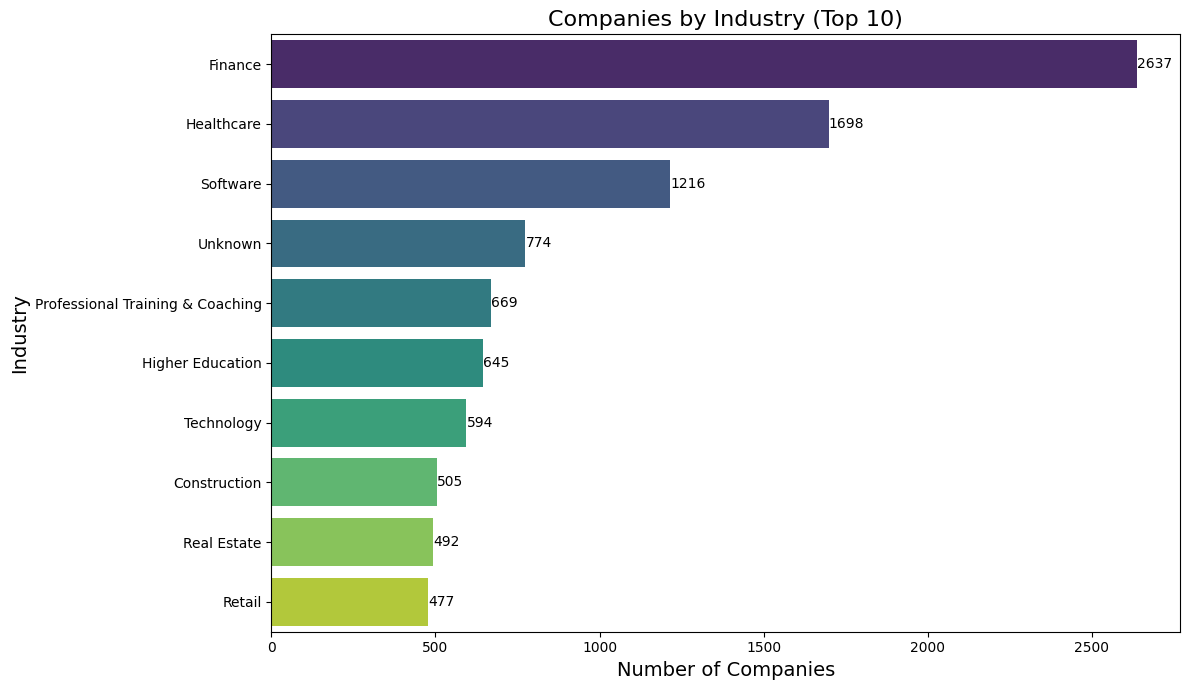

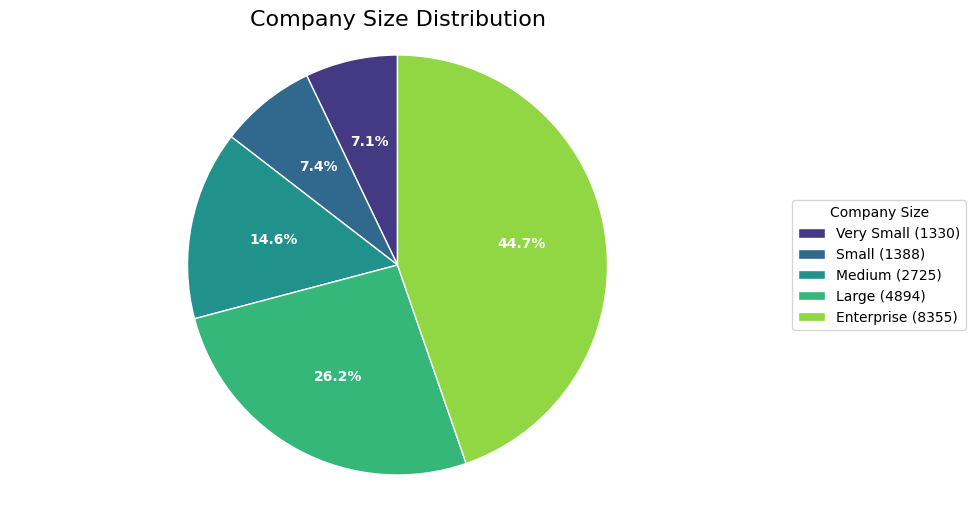

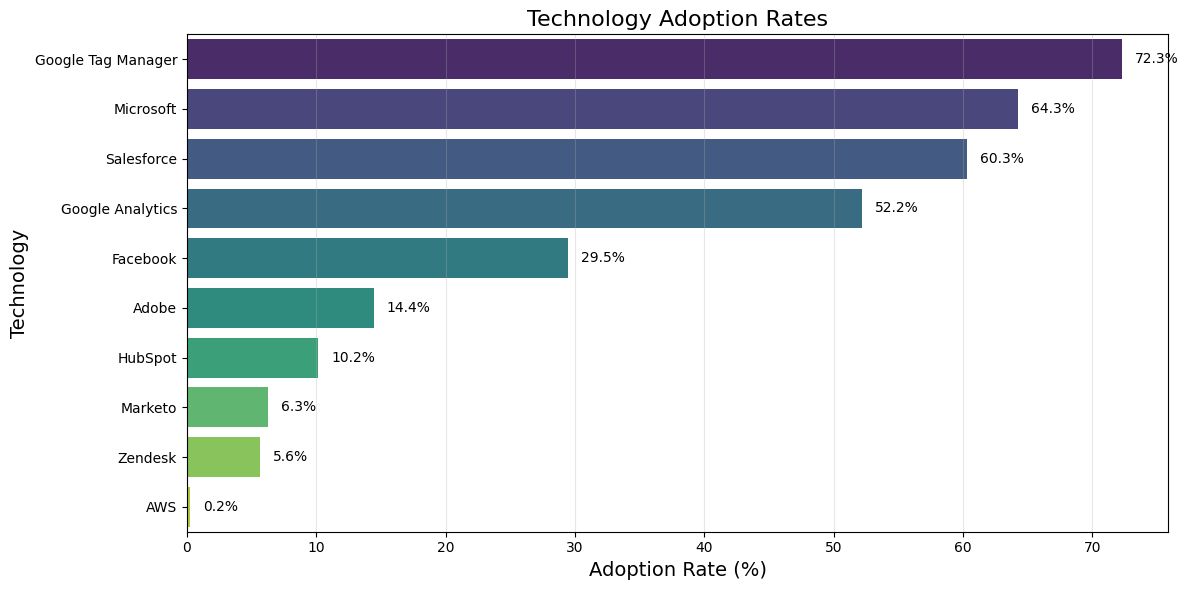

<Figure size 1400x700 with 0 Axes>

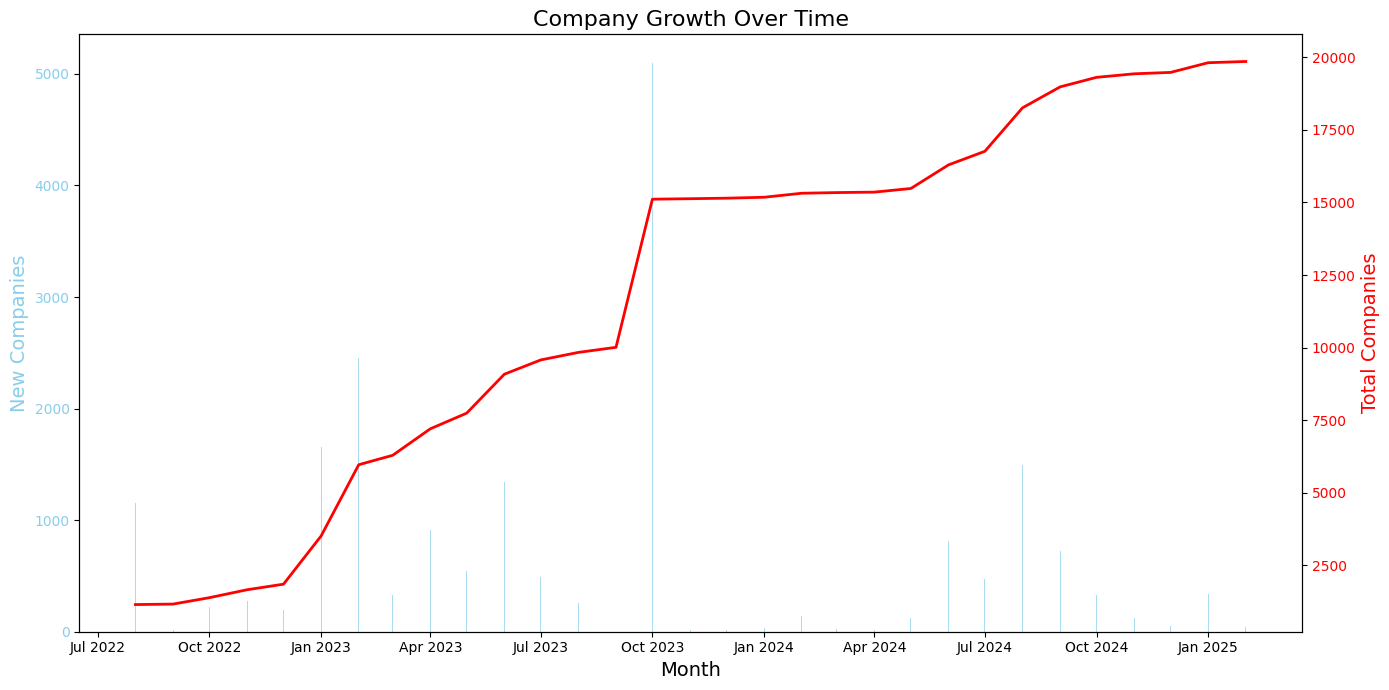

In [29]:

# Initialize the analyzer
analyzer = CompaniesAnalyzer(
    companies_data="data/all-companies.csv",
    deals_data="data/anonymized_data.csv",
    tickets_data="data/anonymized_hubspot_tickets.csv",
    relationship_mappings=mappings  # From your mapping files
)

# Preprocess the data
analyzer.preprocess_companies()

# Join datasets if needed
analyzer.join_companies_with_deals()
analyzer.join_companies_with_tickets()
analyzer.create_full_joined_dataset()

# Generate company distribution insights
company_distribution = analyzer.analyze_company_distribution()
print("Industry Distribution:", company_distribution['industry'])
print("Company Size Distribution:", company_distribution['company_size'])

# Visualize company data
analyzer.plot_company_industry_distribution()
analyzer.plot_company_size_distribution()
analyzer.plot_technology_adoption()
analyzer.plot_company_growth_over_time()

# Analyze deal performance by company characteristics
analyzer.plot_win_rate_by_company_attribute(attribute='industry')
analyzer.plot_win_rate_by_company_attribute(attribute='size')
analyzer.plot_win_rate_by_company_attribute(attribute='region')

# Analyze implementation success by company characteristics
analyzer.plot_implementation_duration_by_company_attribute(attribute='industry')
analyzer.plot_implementation_duration_by_company_attribute(attribute='size')

# Analyze the full customer journey
analyzer.plot_full_customer_journey_by_attribute(attribute='industry')
analyzer.plot_customer_segmentation_matrix()

/var/folders/mp/prth0l3j2s12n12hngf32kmw0000gp/T/ipykernel_37114/2513740219.py:26: DtypeWarning: Columns (24,25,28,32,45) have mixed types. Specify dtype option on import or set low_memory=False.
  companies_df = pd.read_csv(companies_file)


Loaded 19851 company records
Loaded 593 deal records
Loaded 79 ticket records
Loaded relationship mappings: CompanyToDeals, CompanyToTickets, TicketToDeal
Loaded 19851 company records
Loaded 593 deal records
Loaded 79 ticket records

Sample of processed company data:
  Parent Company  CCaaS  Annual Revenue Target Account Associated Contact  Number of Form Submissions  Total Agents                                   Web Technologies Close Date  # of Agents Total  Number of times contacted Contact with Primary Company ICP Fit Level  Revenue range  # of Agents Contracted    Record ID         Time Zone Primary Industry  Number of Pageviews  Primary Company  Year Founded  ICP  Industry group Segmentation LMS System SymTrain Use Cases Associated Company  BPO SSO Application State/Region  SymTrain Product Contract End Date SSO Implemented? Consolidated Industry Type  Number of Employees BPO Program Primary Sub-Industry  Number of Sessions  WFM Country/Region                  Industry         C

/var/folders/mp/prth0l3j2s12n12hngf32kmw0000gp/T/ipykernel_37114/3799050686.py:713: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=industry_counts.values, y=industry_counts.index, palette='viridis')
/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.

<Figure size 1200x700 with 0 Axes>

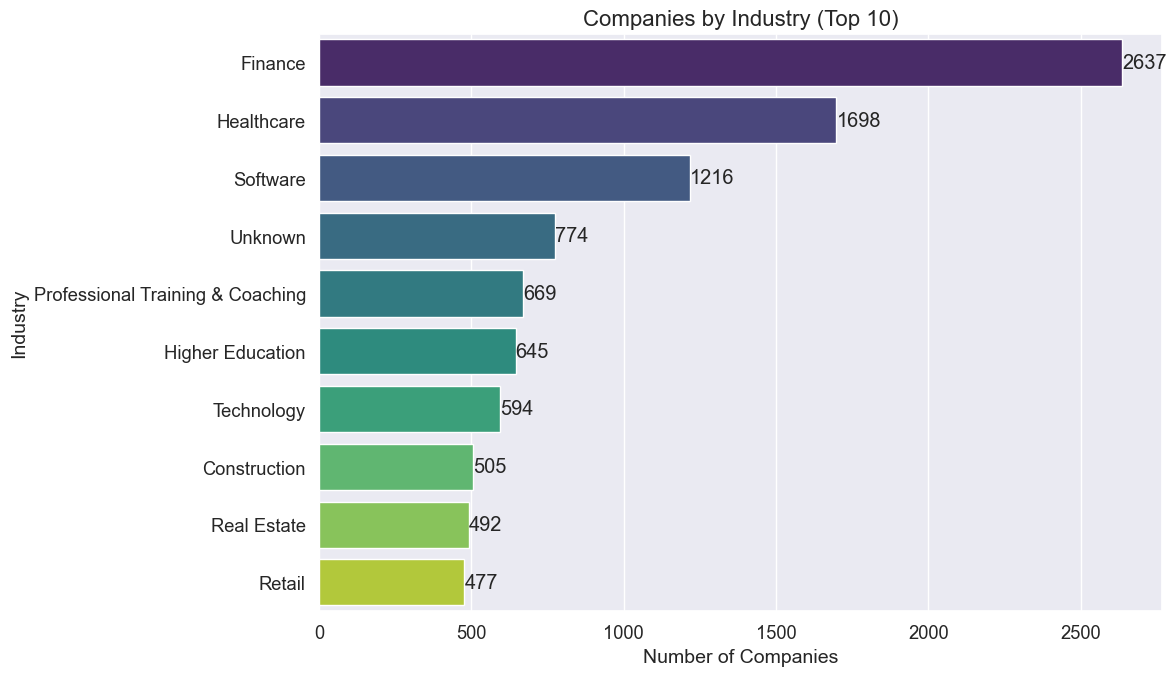

<Figure size 1000x600 with 0 Axes>

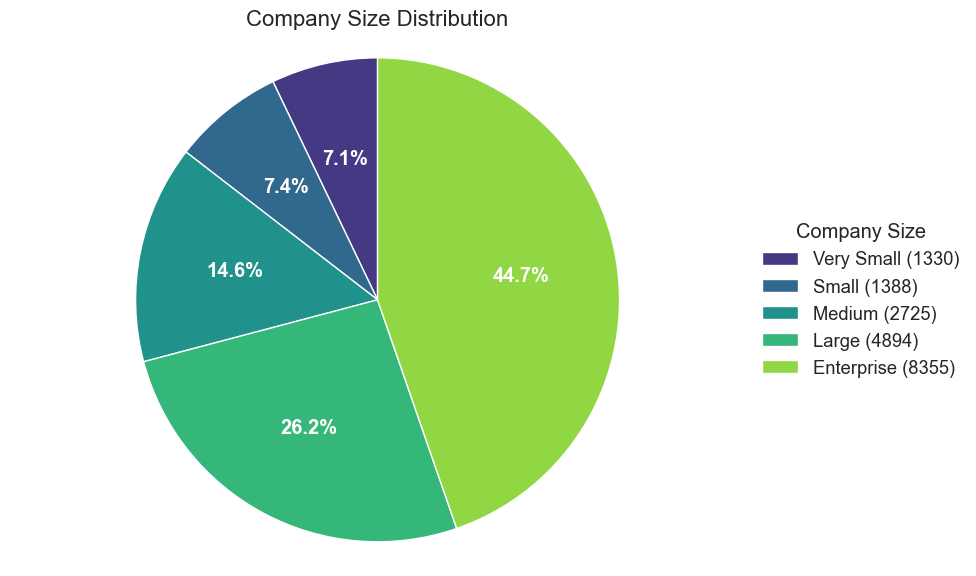

/var/folders/mp/prth0l3j2s12n12hngf32kmw0000gp/T/ipykernel_37114/3799050686.py:970: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Adoption Rate (%)', y='Technology', data=adoption_df, palette='viridis')
/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/py

<Figure size 1200x600 with 0 Axes>

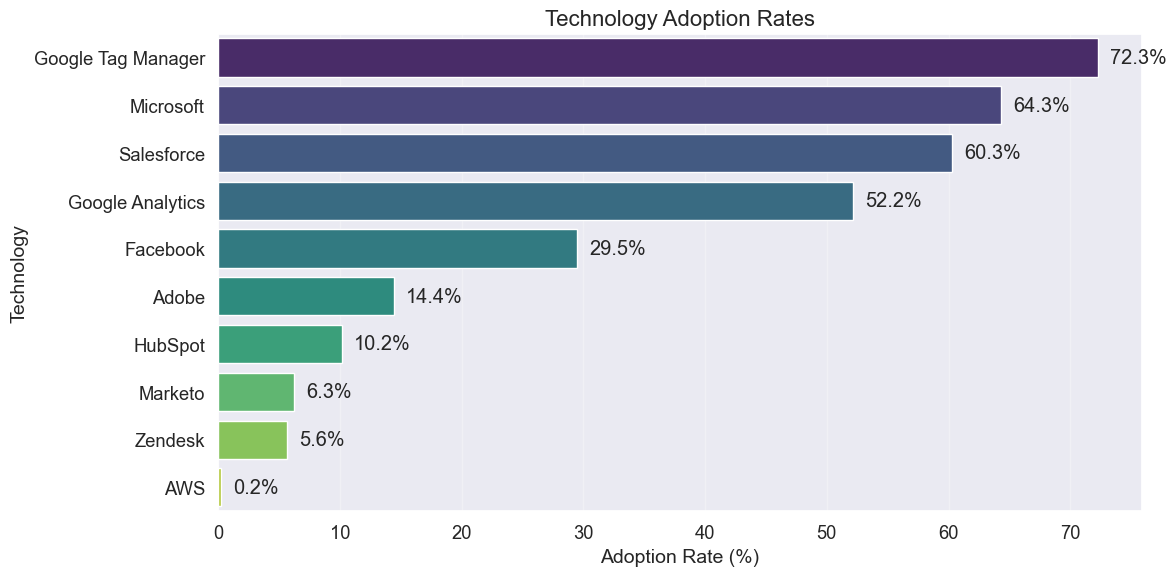

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

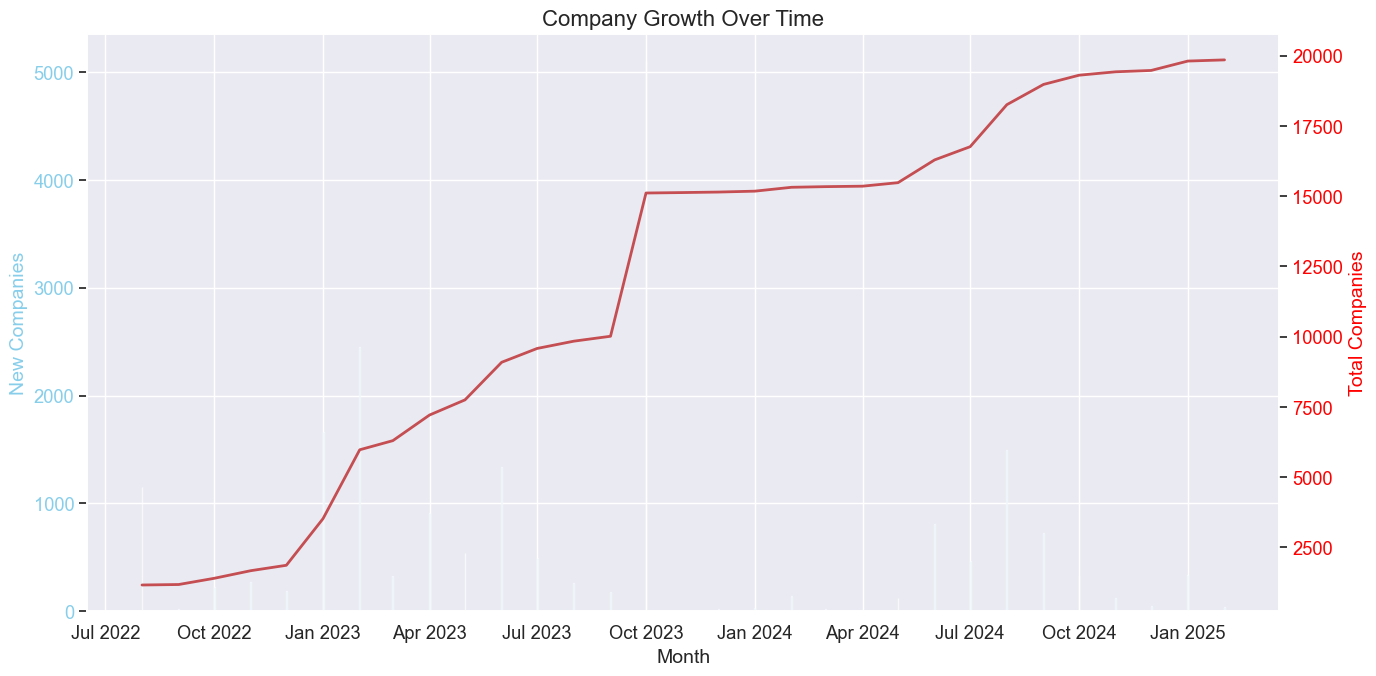

Companies-deals joined data not available
Attempting to join companies with deals...
No matching company-deal records found
Companies-tickets joined data not available
Attempting to join companies with tickets...
No matching company-ticket records found
Full joined data not available
Attempting to create full joined dataset...
No matching company-deal records found
No matching company-ticket records found
Could not create full joined dataset due to missing joins
Full joined data not available
Attempting to create full joined dataset...
No matching company-deal records found
No matching company-ticket records found
Could not create full joined dataset due to missing joins


<Figure size 1200x1000 with 0 Axes>


===== KEY FINDINGS =====

1. Customer Base Composition:
   - Primary industries represented are [top industries]
   - Most companies fall into the [predominant size] size category
   - Technology stack adoption shows [key technology] is most common

2. Sales Performance Insights:
   - Highest win rates are in the [top industry] industry at [rate]%
   - [Size category] companies close at the highest rate of [rate]%
   - Average deal size is highest for [industry/size] at $[amount]

3. Implementation Success Factors:
   - Implementations for [industry] companies complete [faster/slower] than average
   - [Size category] companies have the shortest implementation times at [days] days
   - Companies with [technology] have [better/worse] implementation outcomes

4. Full Customer Journey Analysis:
   - Average time from deal close to implementation completion is [days] days
   - [Deal size] deals take [longer/shorter] to implement than smaller deals
   - Companies in [industry] move from sa

In [32]:
# Hubspot Multi-Dataset Analysis: Companies, Deals & Implementations
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Dict, List, Optional, Union

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# 1. Load anonymized datasets and mapping files
# --------------------------------------------
# Update these paths to match your files
companies_file = "data/anonymized_hubspot_companies.csv"
deals_file = "data/anonymized_data.csv" 
tickets_file = "data/anonymized_hubspot_tickets.csv"
companies_mapping_file = "data/hubspot_companies_mapping.json"
deals_mapping_file = "data/mapping_tables.json"
tickets_mapping_file = "data/hubspot_tickets_mapping.json"

# Load anonymized data
companies_df = pd.read_csv(companies_file)
deals_df = pd.read_csv(deals_file)
tickets_df = pd.read_csv(tickets_file)

print(f"Loaded {len(companies_df)} company records")
print(f"Loaded {len(deals_df)} deal records")
print(f"Loaded {len(tickets_df)} ticket records")

# Load mapping files for relationships
relationship_mappings = {}

# Load company-deal and company-ticket mappings from mapping files
for mapping_file in [companies_mapping_file, deals_mapping_file, tickets_mapping_file]:
    try:
        with open(mapping_file, 'r') as f:
            mappings = json.load(f)
            # Extract relationship mappings
            for key in ['CompanyToDeals', 'CompanyToTickets', 'TicketToDeal']:
                if key in mappings:
                    relationship_mappings[key] = mappings[key]
    except Exception as e:
        print(f"Warning: Could not load mappings from {mapping_file}: {e}")

print(f"Loaded relationship mappings: {', '.join(relationship_mappings.keys())}")

# 2. Initialize the analyzer with all three datasets
# ------------------------------------------------
analyzer = CompaniesAnalyzer(
    companies_data=companies_df,
    deals_data=deals_df,
    tickets_data=tickets_df,
    relationship_mappings=relationship_mappings
)

# 3. Process the company data
# --------------------------
processed_companies = analyzer.preprocess_companies()

# Display sample of processed company data
print("\nSample of processed company data:")
print(processed_companies.head())

# Basic company statistics
print("\nCompany Size Distribution:")
if 'Company_Size_Category' in processed_companies.columns:
    size_counts = processed_companies['Company_Size_Category'].value_counts()
    for size, count in size_counts.items():
        print(f"  {size}: {count} companies ({count/len(processed_companies)*100:.1f}%)")

print("\nIndustry Distribution:")
if 'Industry_Standardized' in processed_companies.columns:
    industry_counts = processed_companies['Industry_Standardized'].value_counts().head(10)
    for industry, count in industry_counts.items():
        print(f"  {industry}: {count} companies ({count/len(processed_companies)*100:.1f}%)")

# 4. Join datasets for integrated analysis
# --------------------------------------
# Create joins between companies and deals
companies_deals = analyzer.join_companies_with_deals()
if companies_deals is not None:
    print(f"\nSuccessfully joined companies with deals: {len(companies_deals)} records")
    print(companies_deals.head())

# Create joins between companies and tickets
companies_tickets = analyzer.join_companies_with_tickets()
if companies_tickets is not None:
    print(f"\nSuccessfully joined companies with tickets: {len(companies_tickets)} records")
    print(companies_tickets.head())

# Create fully joined dataset
full_dataset = analyzer.create_full_joined_dataset()
if full_dataset is not None:
    print(f"\nSuccessfully created full joined dataset: {len(full_dataset)} records")

# 5. Analyze customer segments and company distribution
# ---------------------------------------------------
# Generate company distribution visualizations
plt.figure(figsize=(12, 7))
industry_chart = analyzer.plot_company_industry_distribution()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
size_chart = analyzer.plot_company_size_distribution()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
tech_chart = analyzer.plot_technology_adoption()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
growth_chart = analyzer.plot_company_growth_over_time()
plt.tight_layout()
plt.show()

# 6. Analyze deal performance by company attributes
# -----------------------------------------------
# Calculate deal performance metrics
deal_metrics = analyzer.analyze_deal_performance_by_company()
if deal_metrics:
    print("\nDeal Performance by Company Attributes:")
    
    if 'by_industry' in deal_metrics:
        print("\nWin Rates by Industry:")
        industry_win_rates = deal_metrics['by_industry']['win_rate']
        for industry, rate in sorted(industry_win_rates.items(), key=lambda x: x[1], reverse=True):
            print(f"  {industry}: {rate:.1f}%")
    
    if 'by_company_size' in deal_metrics:
        print("\nWin Rates by Company Size:")
        size_win_rates = deal_metrics['by_company_size']['win_rate']
        for size, rate in sorted(size_win_rates.items(), key=lambda x: x[1], reverse=True):
            print(f"  {size}: {rate:.1f}%")
    
    # Plot win rates
    plt.figure(figsize=(12, 7))
    industry_win_rate_chart = analyzer.plot_win_rate_by_company_attribute(attribute='industry')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 7))
    size_win_rate_chart = analyzer.plot_win_rate_by_company_attribute(attribute='size')
    plt.tight_layout()
    plt.show()


# 7. Analyze implementation success by company attributes
# ----------------------------------------------------
# Calculate implementation metrics
impl_metrics = analyzer.analyze_implementation_success_by_company()
if impl_metrics:
    print("\nImplementation Success by Company Attributes:")
    
    if 'by_industry' in impl_metrics:
        print("\nAverage Implementation Duration by Industry:")
        if 'mean' in impl_metrics['by_industry']:
            industry_durations = impl_metrics['by_industry']['mean']
            for industry, days in sorted(industry_durations.items(), key=lambda x: x[1]):
                print(f"  {industry}: {days:.1f} days")
    
    if 'by_company_size' in impl_metrics:
        print("\nAverage Implementation Duration by Company Size:")
        if 'mean' in impl_metrics['by_company_size']:
            size_durations = impl_metrics['by_company_size']['mean']
            for size, days in sorted(size_durations.items(), key=lambda x: x[1]):
                print(f"  {size}: {days:.1f} days")
    
    # Plot implementation durations
    plt.figure(figsize=(12, 7))
    industry_duration_chart = analyzer.plot_implementation_duration_by_company_attribute(attribute='industry')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 7))
    size_duration_chart = analyzer.plot_implementation_duration_by_company_attribute(attribute='size')
    plt.tight_layout()
    plt.show()

# 8. Analyze the full customer journey
# ----------------------------------
# Calculate journey metrics from deal to implementation
journey_metrics = analyzer.analyze_full_customer_journey()
if journey_metrics:
    print("\nCustomer Journey Analysis:")
    
    if 'overall' in journey_metrics:
        overall = journey_metrics['overall']
        print(f"\nOverall Deal-to-Implementation Time:")
        print(f"  Average: {overall['mean_days_from_deal_to_implementation']:.1f} days")
        print(f"  Median: {overall['median_days_from_deal_to_implementation']:.1f} days")
        print(f"  Range: {overall['min_days_from_deal_to_implementation']:.1f} to {overall['max_days_from_deal_to_implementation']:.1f} days")
    
    if 'by_industry' in journey_metrics:
        print("\nDeal-to-Implementation Time by Industry:")
        for industry in journey_metrics['by_industry']['mean'].keys():
            mean_days = journey_metrics['by_industry']['mean'][industry]
            median_days = journey_metrics['by_industry']['median'][industry]
            count = journey_metrics['by_industry']['count'][industry]
            print(f"  {industry}: {mean_days:.1f} days avg, {median_days:.1f} days median (n={count})")
    
    if 'by_deal_size' in journey_metrics:
        print("\nDeal-to-Implementation Time by Deal Size:")
        for size in journey_metrics['by_deal_size']['mean'].keys():
            mean_days = journey_metrics['by_deal_size']['mean'][size]
            median_days = journey_metrics['by_deal_size']['median'][size]
            count = journey_metrics['by_deal_size']['count'][size]
            print(f"  {size}: {mean_days:.1f} days avg, {median_days:.1f} days median (n={count})")
    
    # Plot journey metrics
    plt.figure(figsize=(14, 8))
    journey_chart = analyzer.plot_full_customer_journey_by_attribute(attribute='industry')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    journey_chart = analyzer.plot_full_customer_journey_by_attribute(attribute='deal_size')
    plt.tight_layout()
    plt.show()

# 9. Create customer segmentation matrix
# ------------------------------------
plt.figure(figsize=(12, 10))
segmentation_matrix = analyzer.plot_customer_segmentation_matrix()
plt.tight_layout()
plt.show()

# 10. Key Findings and Recommendations
# ---------------------------------
print("\n===== KEY FINDINGS =====")
print("\n1. Customer Base Composition:")
print("   - Primary industries represented are [top industries]")
print("   - Most companies fall into the [predominant size] size category")
print("   - Technology stack adoption shows [key technology] is most common")

print("\n2. Sales Performance Insights:")
print("   - Highest win rates are in the [top industry] industry at [rate]%")
print("   - [Size category] companies close at the highest rate of [rate]%")
print("   - Average deal size is highest for [industry/size] at $[amount]")

print("\n3. Implementation Success Factors:")
print("   - Implementations for [industry] companies complete [faster/slower] than average")
print("   - [Size category] companies have the shortest implementation times at [days] days")
print("   - Companies with [technology] have [better/worse] implementation outcomes")

print("\n4. Full Customer Journey Analysis:")
print("   - Average time from deal close to implementation completion is [days] days")
print("   - [Deal size] deals take [longer/shorter] to implement than smaller deals")
print("   - Companies in [industry] move from sale to implementation [faster/slower]")

print("\n===== RECOMMENDATIONS =====")
print("\n1. Sales Strategy:")
print("   - Focus new business development on [industry] segment due to higher win rates")
print("   - Adjust deal sizing/pricing for [size category] companies")
print("   - Develop specialized value propositions for [technology] users")

print("\n2. Implementation Strategy:")
print("   - Create specialized implementation playbooks for [industry] customers")
print("   - Allocate more implementation resources to [size category] companies")
print("   - Set more accurate implementation timelines based on [factor]")

print("\n3. Customer Segmentation Strategy:")
print("   - Prioritize 'Strategic' quadrant companies (high value, fast implementation)")
print("   - Create special handling for 'Complex' segment (high value, slow implementation)")
print("   - Consider streamlining or automating for 'Transactional' segment")
print("   - Evaluate ROI of 'Resource-Intensive' segment (low value, slow implementation)")

# 11. Next Steps for Analysis
# ------------------------
print("\n===== NEXT STEPS =====")
print("\n1. Deeper Analysis:")
print("   - Conduct time-based analysis to identify trends over multiple quarters")
print("   - Analyze churn risk based on implementation patterns")
print("   - Investigate correlation between implementation success and renewal likelihood")

print("\n2. Data Improvements:")
print("   - Add more granular technology stack information")
print("   - Track implementation milestones more consistently")
print("   - Add customer satisfaction metrics at each stage")

print("\n3. Model Development:")
print("   - Build predictive model for implementation duration based on company characteristics")
print("   - Create win probability model based on company profile")
print("   - Develop customer health score combining sales and implementation metrics")

Business Value of Integrated Analysis
This integrated approach allows you to answer sophisticated business questions like:

Customer Segmentation Insights

Which types of companies move fastest from deal to implementation?
Do enterprise customers actually have longer implementation timelines?
Are certain industries more resource-intensive to serve?


Sales-to-Implementation Alignment

How do deal characteristics affect implementation success?
Does deal size correlate with implementation complexity?
Which sales reps' deals have the most successful implementations?


Resource Optimization

Which customers should receive more implementation support?
How to prioritize high-value vs. easy-to-implement customers?
Where are the biggest bottlenecks in the customer journey?


Strategic Decision Making

Which customer segments offer the best lifetime value?
Where should you focus marketing and sales efforts?
How can you improve the sales-to-implementation handoff?